# Data to Strategy with Alpaca
November 24, 2021
    
https://github.com/emskiphoto/Alpaca-Strategy-Development
Copyright 2021 Matt Chmielewski

#### References:
http://localhost:8888/notebooks/ML4T/source/08_ml4t_workflow/04_ml4t_workflow_with_zipline/03_ml4t_with_zipline.ipynb
http://localhost:8888/notebooks/ML4T/source/02_market_and_fundamental_data/01_NASDAQ_TotalView-ITCH_Order_Book/03_normalize_tick_data.ipynb

### Load Dependencies

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
# from alpaca_trade_api.rest import TimeFrame - Won't work 6-11-21
from datetime import datetime, timedelta
import timeit
from alpaca_trade_api.rest import REST
# from alpaca_trade_api.rest import TimeFrame

In [5]:
pd.options.display.max_rows = 300
#     create idx for mutlti-index slicing
idx = pd.IndexSlice

### Check connection to Alpaca

#### Verify Windows Environment Variables are available
API Credentials are stored on Windows PATH variable.  https://dev.to/biplov/handling-passwords-and-secret-keys-using-environment-variables-2ei0

In [6]:
API_credential_vars = ['APCA_API_BASE_URL','APCA_API_KEY_ID', 'APCA_API_SECRET_KEY']
# for var in API_credential_vars:
#     print(os.getenv(var))

### Check Alpaca account

In [7]:
api = tradeapi.REST()
# Get our account information.
account = api.get_account()
# Check if our account is restricted from trading.
if account.trading_blocked:
    print('Account is currently restricted from trading.')
# Check how much money we can use to open new positions.
print('${} is available as buying power.'.format(account.buying_power))

$184481.66 is available as buying power.


### Download Price History

#### Get list of assets

In [8]:
def build_asset_df_alpaca(api, status='active'):
    """Returns a list of assets and trading characteristics as a dataframe"""
    assets = api.list_assets(status=status)
    return pd.DataFrame.from_records([asset._raw for asset in assets.__iter__()])
df_assets = build_asset_df_alpaca(api)
df_assets.head(2)

id      class exchange symbol  \
0  2d9c794e-fd22-4dae-9007-2ccc0ffe328e  us_equity     AMEX   GSAT   
1  5c3aeee2-a86f-4a6e-b0ae-0af0efa0035f  us_equity   NASDAQ  FTCVU   

                               name  status  tradable  marginable  shortable  \
0                  Globalstar, Inc.  active      True        True       True   
1  FinTech Acquisition Corp. V Unit  active      True        True      False   

   easy_to_borrow  fractionable  
0            True         False  
1           False         False

In [9]:
df_assets.groupby(['exchange','marginable']).count().iloc[:,:2]

id  class
exchange marginable             
AMEX     True         263    263
ARCA     True        1788   1788
BATS     True         531    531
NASDAQ   True        4707   4707
NYSE     True        2955   2955
OTC      True           3      3

In [10]:
df_assets['class'].value_counts()

us_equity    10247
Name: class, dtype: int64

## Build OHLCV Database
https://alpaca.markets/docs/api-documentation/api-v2/market-data/alpaca-data-api-v2/

### Iteratively build database

#### Set list of Assets

In [11]:
print(f'There are {df_assets["symbol"].nunique()} assets total')
# assets_query = df_assets['symbol'].sample(10).sort_values().to_list()
assets_query = df_assets['symbol'][:100].sort_values().to_list()
print(f'There are {len(assets_query)} assets in assets_query')
assets_query[:10]

There are 10247 assets total
There are 100 assets in assets_query


['FTCVU',
 'FTDR',
 'FTEC',
 'FTEV',
 'FTEV.U',
 'FTF',
 'FTFT',
 'FTK',
 'FTLB',
 'FTLS']

The rate limit is 200 requests every minute per API key.<BR>
All date time type inputs and outputs are serialized according to ISO8601<BR>


### Query multiple assets - store in single df

In [10]:
def build_multi_symbol_df(assets,start_date = '2021-01-01', end_date = '2021-05-25',
                            frequency='15Min', TZ = 'America/New_York', limit=1000):
    """Returns single multi-index OHLCV time series dataframe for list of assets over input time
    range using Alpaca's API 'get_barset()' method.  'assets' must be input as list.
    Output multi-index is:  symbol, timestamp
    and output columns are: open, high, low, close, volume.
   
    frequency options:
    Day = "1Day"
    Hour = "1Hour"
    15 Minute = '15Min'
    Minute = "1Min"
    Sec = "1Sec"
    
    """
#     reference problematic query (missing bars - not used here):
# TZ = 'America/New_York'
# bars = api.get_barset('AAQC.U', '5Min',
#                           end=pd.Timestamp('2021-05-19', tz=TZ).isoformat(),
#                           limit=1000).df.droplevel(0,axis=1)
# Sort assets for the benefit of future indexing
    assets = sorted(assets)
# Get Name of columns for temp df
    n_assets = len(assets)
    print(f'{n_assets} total assets to query')
    start_date_plus_1 = datetime.strftime(datetime.strptime(start_date,"%Y-%m-%d") + timedelta(days=10),"%Y-%m-%d" )
#     Build empty DataFrame
# Get names of columns based on short query of first asset
    columns = list(api.get_barset(assets[0], frequency,
        start=start_date, end=start_date_plus_1).df.droplevel(0,axis=1).columns)
#     Create empty dataframe as multiindex to hold bars responses
    temp = pd.DataFrame(columns=['symbol',
             'timestamp'] + columns).set_index(['symbol','timestamp']).asfreq(frequency)
    bars_ = []
    bars = []

#     Set dates
    end_date_range = pd.to_datetime(pd.Timestamp(end_date, tz=TZ).isoformat())
    start_date_dt = pd.to_datetime(pd.Timestamp(start_date, tz=TZ).isoformat())
    print(start_date_dt, "\n", end_date_range)
# Iterate through assets:
    for idx, symbol in enumerate(assets):
#         update start_date_dt
        print(f'== {idx + 1} of {n_assets} querying "{symbol}" from {start_date_dt} to {end_date_range} ==')
#       
        #         limit date range to not exceed API's bars limit
        count = 0
        end_date_dt = end_date_range
        last_index_start = end_date_range
        while end_date_dt.to_pydatetime() >= start_date_dt.to_pydatetime():
            count+=1
            print(f'Chunk {count} - {symbol} desired end date:  {end_date_dt}')
#             print(f'end Date is: {end_date_dt}')
# Chunked query starts with end date and works backwards in time to start date
            bars = api.get_barset(symbol, frequency,
                                  end=end_date_dt.isoformat(),
                                  limit=limit).df.droplevel(0,axis=1)

            print(f'Bars shape:  {bars.shape}')
#     Check if bars is empty, if so break out of loop
            try:
                bars.index[0]
            except:
                break
#     Break out of loop if start date repeats (indicating no history prior to start date available)
            if bars.index[0].to_pydatetime() == last_index_start:
                print(f'<<<<<  No history prior to {last_index_start} available for {symbol}  >>>>>\n\n')
                break
            last_index_start = bars.index[0].to_pydatetime()
            print(f'{symbol} chunk {count} index start:  {bars.index[0]}')
#             print(f'Start of barset index {bars.index[0]}')
            print(f'{symbol} chunk {count} index end:   {bars.index[-1]}')
# If an empty 'bars' is returned, skip to next asset
            if len(bars.index) < 1:
                break
            
#             end of date range based on chunk size:
# For testing:
#             start_date_dt = datetime.strptime(start_date_str,"%Y-%m-%d") + timedelta(days=10)

#             Reset chunk end date to be one period before the start of the last chunk that was queried
            end_date_dt = pd.Timestamp(bars.index[0]) - pd.Timedelta(frequency)
            print(f'Is {end_date_dt.to_pydatetime()} less than {start_date_dt.to_pydatetime()}'
                  f': {end_date_dt.to_pydatetime() < start_date_dt.to_pydatetime()}\n')
#     slice off records with dates outside of input start and end dates and set index frequency of df
#             bars = bars.loc[start_date:end_date]
#             bars = bars.loc[start_date:end_date]
            bars = bars.loc[start_date:end_date].asfreq(frequency).sort_index()
#             print(bars.index)
#     Create multi-index as list of tuples
            unique_timestamps = bars.index.unique()
            idx_tuples = [(symbol,timestamp) for timestamp in unique_timestamps]
#             idx_tuples = [(symbol,timestamp) for timestamp in bars.index]
            bars.set_index(pd.Index(idx_tuples), inplace=True)
            bars.rename_axis(['symbol','timestamp'], inplace=True)
            bars_.append(bars)
        
#         #     Drop duplicate indices, if needed
#         unique_idx = bars_.index.drop_duplicates(keep='first')
#         bars_ = bars.loc[unique_idx]
        
# completed compiling bars_, now commit to dataframe
    df = pd.concat([temp] + bars_)
#     set frequency of datetime index
    df.index.levels[1].freq = frequency
# If there is a volume column fill any NaN and convert to integer
    if 'volume' in df.columns:
#         df['volume'] = df['volume'].interpolate().astype('int')
        df['volume'] = df['volume'].astype('int', errors='ignore')
#     df.index = df.index.tz_convert('America/New_York')
# Sort symbols and timestamps alphabetically and chronologically
#     df.sort_index(level=['symbol','timestamp'], inplace=True)
#     remove records where OHLC are all NaN
    df = df.dropna(subset=['open','high','low','close'], how='all')
#     Sort datetime index
#     df.
#     OPTIONAL Quality Check process:
#     for symbol in df.index.get_level_values(0).unique():
#         print(symbol)
#         print(df.loc[idx[symbol,:],'close'].shape[0])
#         print(df.loc[idx[symbol,:],'close'].count())

    return df
    del bars_, df


### Query assets

#### Asset query parameters
In the future, implement a 'class' to manage attributes of queries

In [11]:
frequency = '15Min'
start_date = '2020-01-01'
end_date = '2021-05-30'
TZ = 'America/New_York'

In [12]:
%timeit
test_list = ['ACSI', 'AHT', 'TMAT', 'AROC', 'BBUS', 'CAT','AMAM']
# df = build_multi_symbol_df(test_list,start_date = '2021-01-01', end_date = '2021-05-25',
#                           frequency='15Min', TZ = 'America/New_York', limit=1000)
# df = build_multi_symbol_df(assets_query[:10],start_date = '2020-01-01', end_date = '2021-05-25',
#                           frequency='5Min', TZ = 'America/New_York', limit=1000)
# df = build_multi_symbol_df(assets_query,start_date = '2016-01-01', end_date = '2021-05-30',
#                           frequency='15Min', TZ = 'America/New_York', limit=1000)
# df = build_multi_symbol_df(test_list,start_date = '2020-01-01', end_date = '2021-05-30',
#                           frequency='15Min', TZ = 'America/New_York', limit=1000)
df = build_multi_symbol_df(test_list,start_date = start_date, end_date = end_date,
                          frequency=frequency, TZ = TZ, limit=1000)

7 total assets to query
2020-01-01 00:00:00-05:00 
 2021-05-30 00:00:00-04:00
== 1 of 7 querying "ACSI" from 2020-01-01 00:00:00-05:00 to 2021-05-30 00:00:00-04:00 ==
Chunk 1 - ACSI desired end date:  2021-05-30 00:00:00-04:00
Bars shape:  (348, 5)
ACSI chunk 1 index start:  2016-11-01 12:45:00-04:00
ACSI chunk 1 index end:   2021-02-26 12:15:00-05:00
Is 2016-11-01 12:30:00-04:00 less than 2020-01-01 00:00:00-05:00: True

== 2 of 7 querying "AHT" from 2020-01-01 00:00:00-05:00 to 2021-05-30 00:00:00-04:00 ==
Chunk 1 - AHT desired end date:  2021-05-30 00:00:00-04:00
Bars shape:  (1000, 5)
AHT chunk 1 index start:  2021-04-07 15:45:00-04:00
AHT chunk 1 index end:   2021-05-28 15:45:00-04:00
Is 2021-04-07 15:30:00-04:00 less than 2020-01-01 00:00:00-05:00: False

Chunk 2 - AHT desired end date:  2021-04-07 15:30:00-04:00
Bars shape:  (1000, 5)
AHT chunk 2 index start:  2021-02-11 10:00:00-05:00
AHT chunk 2 index end:   2021-04-07 15:30:00-04:00
Is 2021-02-11 09:45:00-05:00 less than 2020

Chunk 10 - CAT desired end date:  2020-01-17 11:15:00-05:00
Bars shape:  (1000, 5)
CAT chunk 10 index start:  2019-11-15 15:30:00-05:00
CAT chunk 10 index end:   2020-01-17 11:15:00-05:00
Is 2019-11-15 15:15:00-05:00 less than 2020-01-01 00:00:00-05:00: True

== 7 of 7 querying "TMAT" from 2020-01-01 00:00:00-05:00 to 2021-05-30 00:00:00-04:00 ==
Chunk 1 - TMAT desired end date:  2021-05-30 00:00:00-04:00
Bars shape:  (203, 5)
TMAT chunk 1 index start:  2021-01-29 10:15:00-05:00
TMAT chunk 1 index end:   2021-05-12 15:15:00-04:00
Is 2021-01-29 10:00:00-05:00 less than 2020-01-01 00:00:00-05:00: False

Chunk 2 - TMAT desired end date:  2021-01-29 10:00:00-05:00
Bars shape:  (0, 5)


#### Save df to disk

In [13]:
# df.to_csv(f'data/{df.index.levels[0].nunique()}_symbols_2020-01-01_to_2021-05-30_raw.csv')

#### Was full time range of data queried?

In [14]:
start_date == datetime.strftime(df.index.levels[1].min(), "%Y-%m-%d")

False

In [15]:
end_date == datetime.strftime(df.index.levels[1].max(), "%Y-%m-%d")

False

In [16]:
start_date, df.index.levels[1].min(), end_date, df.index.levels[1].max()

('2020-01-01',
 Timestamp('2020-01-02 09:30:00-0500', tz='America/New_York', freq='15T'),
 '2021-05-30',
 Timestamp('2021-05-28 15:45:00-0400', tz='America/New_York', freq='15T'))

#### Are there gaps in the dates or times of the time series?

In [17]:
df.head(10)
# df.head(15).dropna(subset=['open','high','low','close'], how='all')

open   high    low  close  volume
symbol timestamp                                                    
ACSI   2020-02-25 15:45:00-05:00  35.27  35.27  35.27  35.27   100.0
       2020-03-13 11:15:00-04:00  27.84  27.84  27.84  27.84   100.0
       2020-03-18 13:45:00-04:00  25.58  25.58  25.58  25.58   100.0
       2020-07-18 08:00:00-04:00  34.86  35.02  34.86  34.96   500.0
       2020-07-18 08:15:00-04:00  34.96  35.00  34.80  35.00   800.0
       2020-07-18 08:30:00-04:00  34.94  35.01  34.88  34.88   600.0
       2020-07-18 08:45:00-04:00  34.91  35.01  34.84  34.84   700.0
       2020-07-18 09:00:00-04:00  34.85  34.90  34.85  34.90   300.0
       2020-07-18 09:15:00-04:00  34.94  34.99  34.83  34.91   600.0
       2020-07-18 09:30:00-04:00  34.87  34.97  34.82  34.87   600.0

#### How many rows of data does each symbol have?

In [18]:
for symbol in df.index.levels[0]:
    print(symbol, ":  ", df.loc[idx[symbol,:]].shape[0], " rows")

ACSI :   33  rows
AHT :   8532  rows
AROC :   9008  rows
BBUS :   375  rows
CAT :   9294  rows
TMAT :   203  rows


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27445 entries, ('ACSI', Timestamp('2020-02-25 15:45:00-0500', tz='America/New_York', freq='15T')) to ('TMAT', Timestamp('2021-05-12 15:15:00-0400', tz='America/New_York', freq='15T'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    27445 non-null  float64
 1   high    27445 non-null  float64
 2   low     27445 non-null  float64
 3   close   27445 non-null  float64
 4   volume  27445 non-null  float64
dtypes: float64(5)
memory usage: 1.6+ MB


### Clean & Filter data

#### Infer market days and market hours from df
Data supplied contains market and after hours data. Identifying market days and market hours enables segregation of market and non-market hours data.

In [20]:
def aggregate_daily_trade_count_from_df(df, n_symbols=5, min_trade_count_pct = 0.025):
    """Returns numerical indices for only df records containing dates with measurable market activity
    (df record count > min_trade_count_pct).  
    n_symbols: the minimum number of symbols in the df
    that are considered out of all symbols in df.
    min_trade_count_pct:  the minimum normalized count percentage of historical trades (i.e. total
    aggregated trade count for a given hour divided my max trade count of any hour) needed
    to distinguish low volume trading hours (i.e. outside market hours) from high volume
    trading hours"""
#     create idx for mutlti-index slicing
    idx = pd.IndexSlice
#     find symbols with highest rates of complete data
    symbols = df.index.get_level_values(0).unique().to_list()
    counts = [df.loc[idx[symbol,:],'close'].count() for symbol in symbols]
    lengths = [df.loc[idx[symbol,:],'close'].shape[0] for symbol in symbols]
    pct_completes = [count/length for count, length in zip(counts, lengths)]
#     obtain indices of largest pct_completes values, then analyze top n symbols 
    pct_ranked_idx = sorted(range(len(pct_completes)), key=lambda x: pct_completes[x],reverse=True)
    analysis_symbols = [symbols[x] for x in pct_ranked_idx][:min(n_symbols,len(symbols))]
#     Get aggregate count of transactions by hour of day then normalize values
    agg_trade_count_by_day = df.loc[idx[analysis_symbols,:],'close']\
        .groupby(df.loc[idx[analysis_symbols,:],'close'].index.get_level_values(1).date).count()
    return agg_trade_count_by_day

In [21]:
agg_trade_count_by_day = aggregate_daily_trade_count_from_df(df, n_symbols=5, min_trade_count_pct = 0.025)
agg_trade_count_by_day

2020-01-02    77
2020-01-03    78
2020-01-06    78
2020-01-07    78
2020-01-08    79
              ..
2021-05-24    80
2021-05-25    78
2021-05-26    75
2021-05-27    73
2021-05-28    78
Name: close, Length: 357, dtype: int64

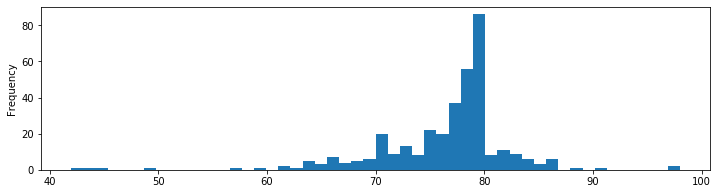

In [22]:
# agg_trade_count_by_day.plot(kind='bar',figsize=(12,5))
agg_trade_count_by_day.plot(kind='hist', bins=50,figsize=(12,3))

In [23]:
def market_days_from_df(agg_trade_count_by_day):
    """Function assumes any dates missing in input df are days where the 
    market is closed.  Returns datetime series of market days"""
    return pd.to_datetime(agg_trade_count_by_day.index)

In [24]:
market_dates = market_days_from_df(agg_trade_count_by_day)

In [25]:
market_dates

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2021-05-17', '2021-05-18', '2021-05-19', '2021-05-20',
               '2021-05-21', '2021-05-24', '2021-05-25', '2021-05-26',
               '2021-05-27', '2021-05-28'],
              dtype='datetime64[ns]', length=357, freq=None)

### Determine Market Hours from source data

In [26]:
def infer_market_hours_from_df(df, n_symbols=5, min_trade_count_pct = 0.2):
    """Returns 'market_open' and 'market_close' from multi-index df containing full-day 
    time-series data.  
    n_symbols: the minimum number of symbols in the df
    that are considered out of all symbols in df.
    min_trade_count_pct:  the minimum normalized count percentage of historical trades (i.e. total
    aggregated trade count for a given hour divided my max trade count of any hour) needed
    to distinguish low volume trading hours (i.e. outside market hours) from high volume
    trading hours"""
#     create idx for mutlti-index slicing
    idx = pd.IndexSlice
#     find symbols with highest rates of complete data
    symbols = df.index.get_level_values(0).unique().to_list()
    counts = [df.loc[idx[symbol,:],'close'].count() for symbol in symbols]
    lengths = [df.loc[idx[symbol,:],'close'].shape[0] for symbol in symbols]
    pct_completes = [count/length for count, length in zip(counts, lengths)]
#     obtain indices of largest pct_completes values, then analyze top n symbols 
    pct_ranked_idx = sorted(range(len(pct_completes)), key=lambda x: pct_completes[x],reverse=True)
    analysis_symbols = [symbols[x] for x in pct_ranked_idx][:min(n_symbols,len(symbols))]
#     Get aggregate count of transactions by hour of day then normalize values
    agg_trade_count_by_time = df.loc[idx[analysis_symbols,:],'close']\
        .groupby(df.loc[idx[analysis_symbols,:],'close'].index.get_level_values(1).time).count()
    max_count = agg_trade_count_by_time.max()
    normed_agg_trade_count_by_time = agg_trade_count_by_time/max_count
    # Identify first and last hour where aggregate transaction count > min_trade_count_pct
    times_w_count_gt_threshold = [idx for idx in normed_agg_trade_count_by_time.index if normed_agg_trade_count_by_time[idx] > min_trade_count_pct  ]
    market_open, market_close = times_w_count_gt_threshold[0],times_w_count_gt_threshold[-1]
    return market_open, market_close


In [27]:
market_open, market_close = infer_market_hours_from_df(df, n_symbols=10)
market_open, market_close

(datetime.time(9, 30), datetime.time(15, 45))

#### Create a perfect, complete datetime index to reindex raw data

In [28]:
datetime_idx_complete = pd.date_range(start=df.index.levels[1].min(), end=df.index.levels[1].max(), freq=df.index.levels[1].freq)
datetime_idx_complete

DatetimeIndex(['2020-01-02 09:30:00-05:00', '2020-01-02 09:45:00-05:00',
               '2020-01-02 10:00:00-05:00', '2020-01-02 10:15:00-05:00',
               '2020-01-02 10:30:00-05:00', '2020-01-02 10:45:00-05:00',
               '2020-01-02 11:00:00-05:00', '2020-01-02 11:15:00-05:00',
               '2020-01-02 11:30:00-05:00', '2020-01-02 11:45:00-05:00',
               ...
               '2021-05-28 13:30:00-04:00', '2021-05-28 13:45:00-04:00',
               '2021-05-28 14:00:00-04:00', '2021-05-28 14:15:00-04:00',
               '2021-05-28 14:30:00-04:00', '2021-05-28 14:45:00-04:00',
               '2021-05-28 15:00:00-04:00', '2021-05-28 15:15:00-04:00',
               '2021-05-28 15:30:00-04:00', '2021-05-28 15:45:00-04:00'],
              dtype='datetime64[ns, America/New_York]', length=49174, freq='15T')

#### Are there duplicate timestamps within a given symbol's index?

In [49]:
def check_for_duplicated_dt_indices(df):
    print('Does symbol have duplicated timestamps in datetime index?')
    symbol_dt_index_duplicated = []
    duplicated_dt_index = {}
    symbols = df.index.get_level_values(0).unique()
    for symbol in symbols:
        duplicated_dt_index = df.loc[idx[symbol,:]].index.has_duplicates
        print(f'{symbol}: {duplicated_dt_index}')    
        symbol_dt_index_duplicated.append(duplicated_dt_index)
    duplicated_dt_index = dict(zip(symbols,symbol_dt_index_duplicated ))
    return duplicated_dt_index

In [50]:
duplicated_dt_index = check_for_duplicated_dt_indices(df)

Does symbol have duplicated timestamps in datetime index?
ACSI: False
AHT: False
AROC: False
BBUS: False
CAT: False
TMAT: False


### Fill gaps in datetime index

In [31]:
# just in case....
df_backup = df.copy()
# df = df_backup.copy()

In [42]:
def fill_OHLCV_gaps(df):
    """Returns complete time series from input OHLCV time series dataframe.
    Input dataframe must have timezone aware datetime index with a defined 
    frequency and can be single or dual indexed (ex. ['symbol', 'timestamp']).   
    NaN records leading up to first non-NaN record are returned unaltered.
    
    The OHLC data 
    is forward filled and NaNs in the volume data should be filled
    with '0'. This is because NaNs in price data should carry forward the
    last prices - the assumption is that if there are no new transactions 
    (i.e. volume = 0) then the most recent valid price is also the current
    valid price. Volume NaNs should be filled with '0' because if there were
    no prices or volume reported for a given timestamp it means there was no volume.
    Goal is to revise time series so that no records are NaN in the time series and
    no timestamp gaps in the time series sequence."""
    
    OHLC_cols = ['open','high','low','close']
    
    def process_df(df, symbol, datetime_idx_complete):
        """Different fill logic is needed for OHLC and volume data. 
        The OHLC data should be forward filled and NaNs in the volume
        data should be filled with '0'. This is because NaNs in price
        data should carry forward the last prices - the assumption is
        that if there are no new transactions (volume = 0) than the most 
        recent valid price is also the current valid price. Volume NaNs 
        should be filled with '0' because if there were no prices or volume
        reported for a given timestamp it means there was no volume.
        
        Leading NaN OHLC records with 0 volume remain NaN - that is OK as 
        we don't want to back fill leading NaNs.  It's better to not have 
        the data and omit the first n records than to force assumed values 
        on leading data.

        It can be seen that OHLC prices for 0-volume intervals are not NaN 
        and remain constant over intervals until volume > 0 - this is good.  """
    #             create df single index df and reindex to achieve complete datetime index
        df = df.reindex(datetime_idx_complete)
#                 fill NaN in volume columns with 0

        df['volume'] = df['volume'].fillna(0) 
#                 forward fill OHLC columns
        df[OHLC_cols] = df[OHLC_cols].ffill()
        return df
        
#     check if df is a multi-index
    is_multi_idx = isinstance(df.index, pd.MultiIndex)
    
    if is_multi_idx:
        idx = pd.IndexSlice
    #     generate a complete datetime index for dates in between min and max dates
#     this will be the new datetime index
        datetime_idx_complete = pd.date_range(start=df.index.levels[1].min(),
                                          end=df.index.levels[1].max(),
                                          freq=df.index.levels[1].freq)
        symbols = df.index.levels[0].sort_values().unique()
#         dictionary to store multiple dfs
        symbols_dict = {}
        for symbol in symbols:
            symbols_dict[symbol] = process_df(df.loc[idx[symbol,:]], symbol, datetime_idx_complete)
# combine all dfs stored in symbols_dict as multi-index
        df = pd.concat(symbols_dict)
            
    else:
        print('Function Not Ready Yet')
        datetime_idx_complete = pd.date_range(start=df.index[0],
                                          end=df.index[-1],
                                          freq=df.index.freq)
        df = process_df(df, symbol, datetime_idx_complete)
    
    return df

In [37]:
df = fill_OHLCV_gaps(df)

ACSI


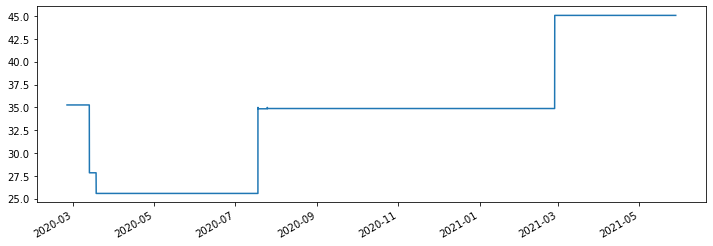

AHT


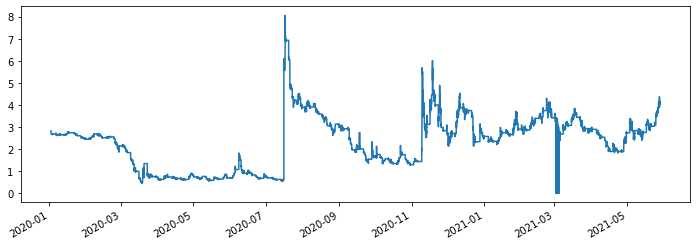

AROC


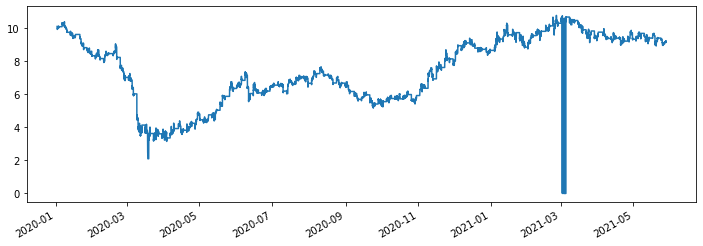

BBUS


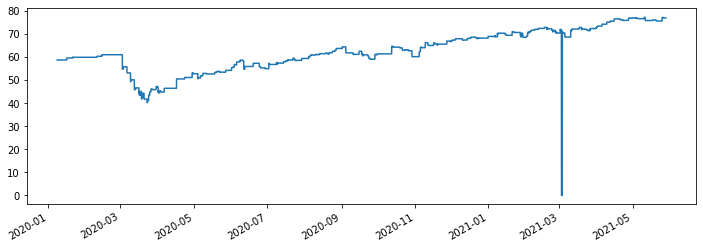

CAT


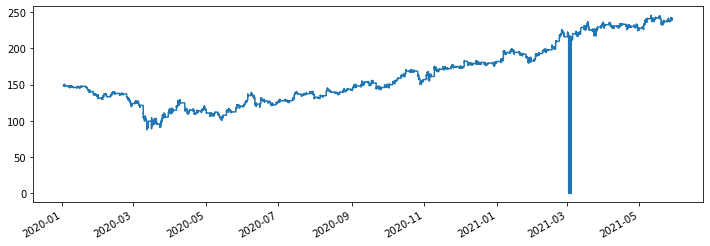

TMAT


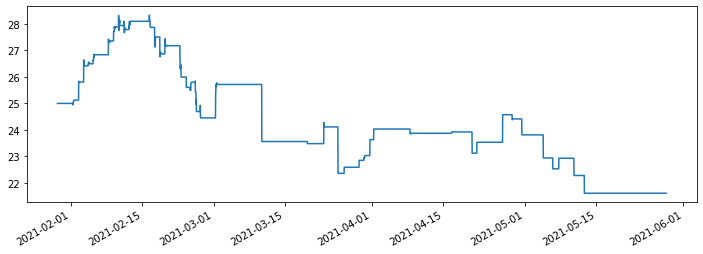

In [38]:
for symbol in df.index.levels[0].unique():
    df.loc[idx[symbol], 'close'].plot(figsize=(12,4))
    print(symbol)
    plt.show()

In [39]:
df.tail()

open   high    low  close  volume
TMAT 2021-05-28 14:45:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:00:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:15:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:30:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:45:00-04:00  21.61  21.61  21.61  21.61     0.0

#### How many rows of a reindexed time series are NaN?

In [41]:
df.loc[idx['ACSI',:]].reindex(datetime_idx_complete).isna().sum(axis=1).value_counts()

0    43965
4     5209
dtype: int64

### Slice df to market hours only

In [51]:
def slice_to_market_hours(df, market_open, market_close):
    from_ = market_open.strftime("%H:%M")
    to_ = market_close.strftime("%H:%M")
    idxs = df.index.get_level_values(1).indexer_between_time(from_, to_)
    return df.iloc[idxs]

In [86]:
# from_ = market_open.strftime("%H:%M")
# to_ = market_close.strftime("%H:%M")
# #     global idxs
# idxs = df.index.get_level_values(1).indexer_between_time(from_, to_)
# idxs

In [85]:
# df.index.get_level_values(1).hour.value_counts()

In [83]:
# df.index.get_level_values(1)

In [82]:
# df.index.levels[1].hour.value_counts()

In [84]:
# df_backup.index.get_level_values(1).hour.value_counts()

ACSI


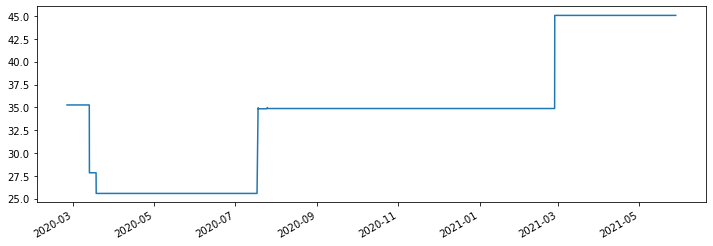

AHT


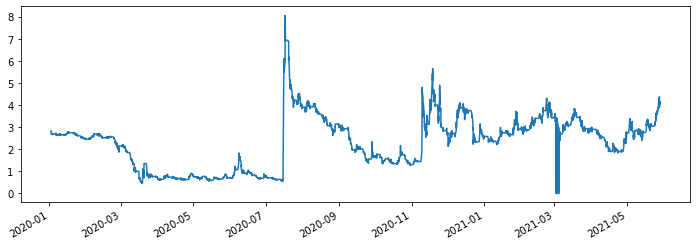

AROC


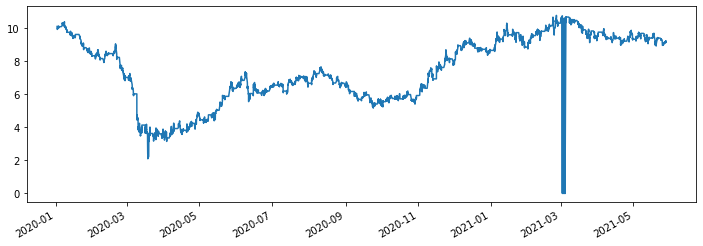

BBUS


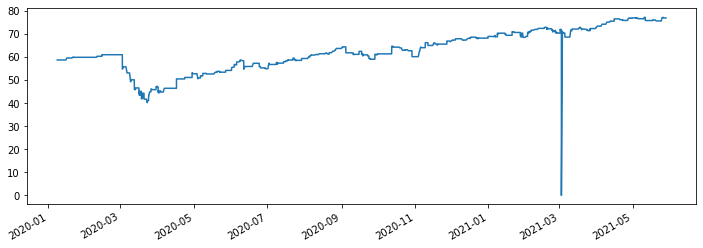

CAT


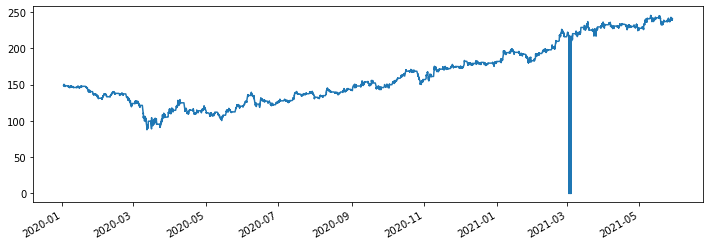

TMAT


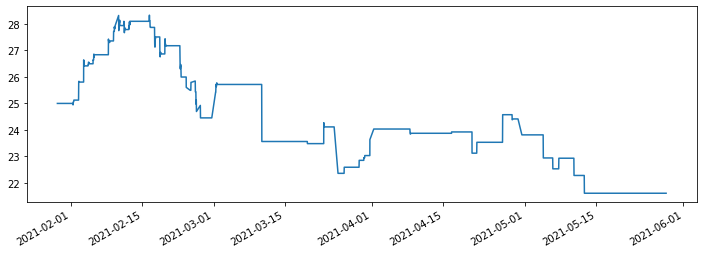

In [63]:
for symbol in df.index.levels[0].unique():
    df.loc[idx[symbol], 'close'].plot(figsize=(12,4))
    print(symbol)
    plt.show()

In [68]:
df.index.levels[1].hour.value_counts()

11    2052
1     2052
15    2052
14    2052
13    2052
12    2052
10    2052
9     2050
3     2048
4     2048
5     2048
6     2048
7     2048
8     2048
23    2048
22    2048
16    2048
17    2048
18    2048
19    2048
20    2048
21    2048
0     2048
2     2040
dtype: int64

### Slice df to market days only

In [257]:
def infer_market_days(df):
    """Distinguish market days from non-market (market closed days) based on daily volumes.
    Daily mean volumes are divided in to a number of bins that is equal to the number of weeks
    in the data.  The upper edge of the lowest volume bin is used to define the threshold between 
    active market volume and a closed market.
    
    Function is intended for multi-index dfs with data from the same market.  Do not use
    for a mix of markets.   The more symbols with more volumne in the df, the more reliable
    the result"""
    from numpy import histogram
#     want to identify days where market is closed, (including holidays) so resample to days
    df_daily_volume = df['volume'].resample('D', level=1).mean()
    n_weeks = df_daily_volume.shape[0]//7
    hist_ = histogram(df_daily_volume, bins=n_weeks)
#     This is the right hand edge of the first histogram bin
    volume_threshold = hist_[1][1]
    volume_GT_threshold = df_daily_volume > volume_threshold
    market_open_days = df_daily_volume.index.date[volume_GT_threshold]
#     market_open_day_dates = 
    df_dates = df.index.get_level_values(1)
    df_days = df.index.get_level_values(1).date
    
    market_open_intervals = [interval for interval in df_dates if interval.date() in market_open_days]
#     market_open_intervals = [interval for interval, day in zip(df_dates, df_days) if day in market_open_days]
#     df.index.get_level_values(0)
#     idxs = df.index.get_level_values(1).indexer_between_time(from_, to_)
#     return df.loc[market_open_days]
#     df.index.get_locs([slice(None), market_open_intervals])
#     return market_open_intervals
    return df.iloc[df.index.get_locs([slice(None), market_open_intervals])]
    

In [258]:
%%time
df_mkt = infer_market_days(df)
df_mkt

Wall time: 1min 31s


open   high    low  close  volume
ACSI 2020-01-02 09:30:00-05:00    NaN    NaN    NaN    NaN     0.0
     2020-01-02 09:45:00-05:00    NaN    NaN    NaN    NaN     0.0
     2020-01-02 10:00:00-05:00    NaN    NaN    NaN    NaN     0.0
     2020-01-02 10:15:00-05:00    NaN    NaN    NaN    NaN     0.0
     2020-01-02 10:30:00-05:00    NaN    NaN    NaN    NaN     0.0
...                               ...    ...    ...    ...     ...
TMAT 2021-05-28 14:45:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:00:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:15:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:30:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:45:00-04:00  21.61  21.61  21.61  21.61     0.0

[55380 rows x 5 columns]

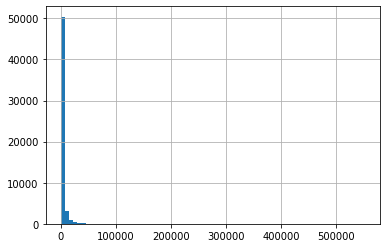

In [262]:
df_mkt['volume'].hist(bins=73)

ACSI


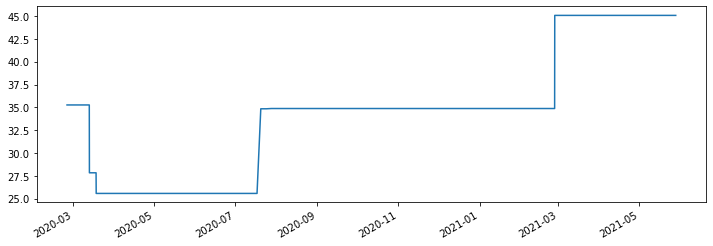

AHT


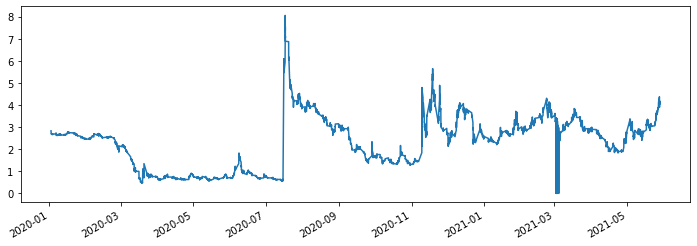

AROC


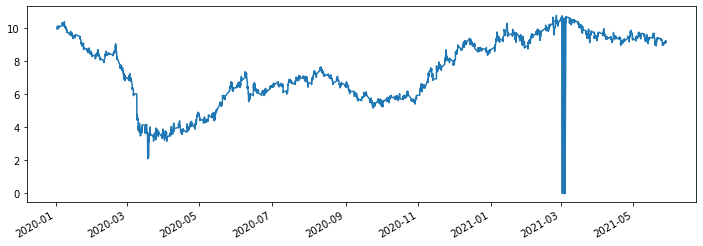

BBUS


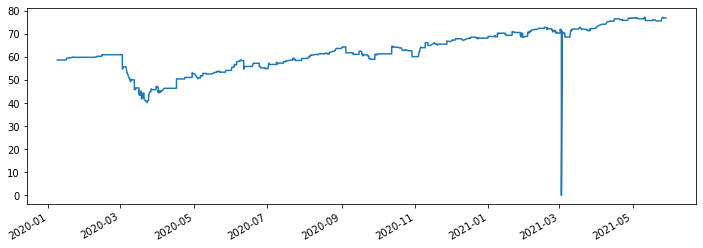

CAT


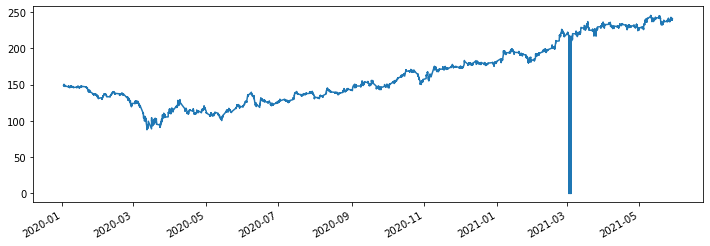

TMAT


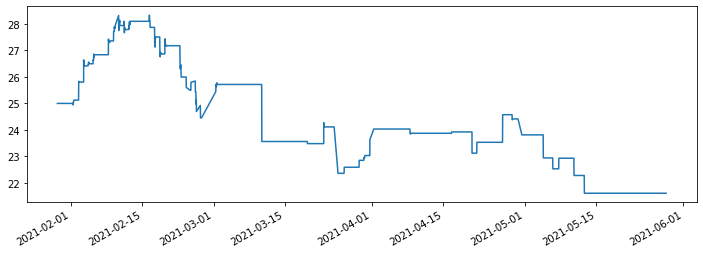

In [264]:
for symbol in df_mkt.index.levels[0].unique():
    df_mkt.loc[idx[symbol], 'close'].plot(figsize=(12,4))
    print(symbol)
    plt.show()

In [186]:
df_daily_volume = df_daily['volume']
df_daily_volume

2020-01-02 00:00:00-05:00    1738.025641
2020-01-03 00:00:00-05:00    1548.967949
2020-01-04 00:00:00-05:00       0.000000
2020-01-05 00:00:00-05:00       0.000000
2020-01-06 00:00:00-05:00    1618.878205
                                ...     
2021-05-24 00:00:00-04:00    1428.724359
2021-05-25 00:00:00-04:00    4087.487179
2021-05-26 00:00:00-04:00    2116.205128
2021-05-27 00:00:00-04:00    2387.089744
2021-05-28 00:00:00-04:00    2393.192308
Freq: D, Name: volume, Length: 513, dtype: float64

In [113]:
df_daily = df.resample('D', level=1).mean()
df_daily

open       high        low      close  \
2020-01-02 00:00:00-05:00  53.894295  53.958141  53.841282  53.914026   
2020-01-03 00:00:00-05:00  53.643974  53.714615  53.579679  53.651667   
2020-01-04 00:00:00-05:00  53.690000  53.783333  53.610000  53.746667   
2020-01-05 00:00:00-05:00  53.690000  53.783333  53.610000  53.746667   
2020-01-06 00:00:00-05:00  53.522628  53.571090  53.485897  53.534423   
...                              ...        ...        ...        ...   
2021-05-24 00:00:00-04:00  65.490353  65.539776  65.438878  65.489327   
2021-05-25 00:00:00-04:00  65.863077  65.912308  65.802179  65.852853   
2021-05-26 00:00:00-04:00  65.624904  65.662692  65.588526  65.625160   
2021-05-27 00:00:00-04:00  66.161058  66.225609  66.111346  66.169904   
2021-05-28 00:00:00-04:00  66.182564  66.232468  66.122468  66.173269   

                                volume  
2020-01-02 00:00:00-05:00  1738.025641  
2020-01-03 00:00:00-05:00  1548.967949  
2020-01-04 00:00:00-05:00     0.000000  
2020-01-05 00:00:00-05:00     0.000000  
2020-01-06 00:00:00-05:00  1618.878205  
...                                ...  
2021-05-24 00:00:00-04:00  1428.724359  
2021-05-25 00:00:00-04:00  4087.487179  
2021-05-26 00:00:00-04:00  2116.205128  
2021-05-27 00:00:00-04:00  2387.089744  
2021-05-28 00:00:00-04:00  2393.192308  

[513 rows x 5 columns]

In [130]:
df_daily['vol_div_by_99_pct'] = df_daily['volume']/df_daily['volume'].quantile(0.99)
# df_daily.groupby(df_daily.index.weekday)['vol_div_by_99_pct'].mean()
df_daily['vol_div_by_99_pct']

2020-01-02 00:00:00-05:00    0.242348
2020-01-03 00:00:00-05:00    0.215986
2020-01-04 00:00:00-05:00    0.000000
2020-01-05 00:00:00-05:00    0.000000
2020-01-06 00:00:00-05:00    0.225734
                               ...   
2021-05-24 00:00:00-04:00    0.199220
2021-05-25 00:00:00-04:00    0.569954
2021-05-26 00:00:00-04:00    0.295081
2021-05-27 00:00:00-04:00    0.332853
2021-05-28 00:00:00-04:00    0.333704
Freq: D, Name: vol_div_by_99_pct, Length: 513, dtype: float64

In [137]:
df_daily['vol_div_by_99_pct'].quantile([0.05,0.1,0.15,0.25, 0.8])

0.05    0.000000
0.10    0.000000
0.15    0.000000
0.25    0.000000
0.80    0.414832
Name: vol_div_by_99_pct, dtype: float64

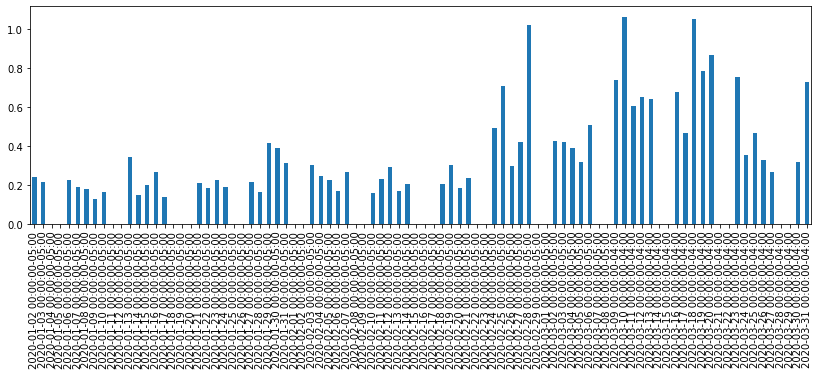

In [155]:
df_daily['vol_div_by_99_pct'][:90].plot(kind='bar', figsize=(14,4))

In [161]:
from numpy import arange, histogram

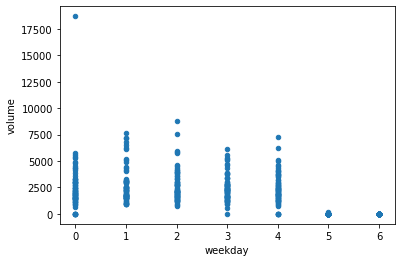

In [126]:
df_daily.assign(weekday = df_daily.index.weekday).plot(kind='scatter', x='weekday',y='volume')

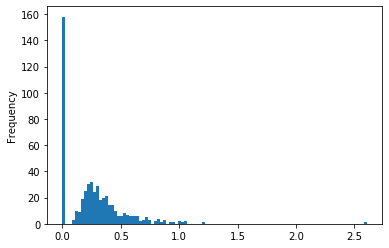

In [119]:
(df_daily['volume']/df_daily['volume'].quantile(0.99)).plot(kind='hist', bins=100)

In [111]:
def resample_to_complete_market_hours(df,market_open, market_close, market_days_idx):
#     market_open, market_close, market_days_idx
    """input multi-index time series df with incomplete/gapped time series and 
    function returns time-series sliced to ma"""

In [112]:
test.loc[TMAT_2021_02_01_idx]\
    .resample('15Min').agg({'open' : 'mean',
                            'high': 'max',
                            'low': 'min',
                            'close': 'last',
                            'volume':'sum'})\
    .reindex(complete_2021_02_01_idx_market_hours).fillna(method='ffill')

NameError: name 'test' is not defined

In [400]:
# df.index.levels[1].sort_values()

In [401]:
# pd.to_datetime(agg_trade_count_by_day.index) == pd.to_datetime(df.index.get_level_values(1).sort_values().date).unique()

In [402]:
# df.loc[idx['CAT',df.index.get_level_values(1)[3]],:]

In [238]:
market_days_idx = infer_market_days_from_df(df, n_symbols=10)
df = df.iloc[market_days_idx]
# market_days_idx[:10]

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27450 entries, ('ACSI', Timestamp('2020-02-25 15:45:00-0500', tz='America/New_York', freq='15T')) to ('CAT', Timestamp('2020-01-17 14:30:00-0500', tz='America/New_York', freq='15T'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    27450 non-null  float64
 1   high    27450 non-null  float64
 2   low     27450 non-null  float64
 3   close   27450 non-null  float64
 4   volume  27450 non-null  float64
dtypes: float64(5)
memory usage: 1.6+ MB


#### Was full time range of data queried?

In [314]:
df.index.levels[1].min(), df.index.levels[1].max()

(Timestamp('2020-01-02 09:30:00-0500', tz='America/New_York', freq='15T'),
 Timestamp('2021-05-28 15:45:00-0400', tz='America/New_York', freq='15T'))

In [212]:
# df['volume'].plot(kind='hist', figsize=(10,4), bins=200)
# plt.xscale('log')
# plt.show()

In [124]:
# df.iloc[:10]
# df.iloc[:10].groupby(['symbol',pd.Grouper(freq='60Min',level=1)]).ohlc()

In [410]:
df.head(5)

open   high    low  close  volume
symbol timestamp                                                    
ACSI   2020-02-25 15:45:00-05:00  35.27  35.27  35.27  35.27   100.0
       2020-03-13 11:15:00-04:00  27.84  27.84  27.84  27.84   100.0
       2020-03-18 13:45:00-04:00  25.58  25.58  25.58  25.58   100.0
       2020-07-18 08:00:00-04:00  34.86  35.02  34.86  34.96   500.0
       2020-07-18 08:15:00-04:00  34.96  35.00  34.80  35.00   800.0

#### The 'TMAT' asset is missing many records
This makes sense as there are periods with no trading activity (volume).  This makes the TMAT data a good subject for subsequent cleaning & processing steps.
1. how to create a complete time series with no NaNs?
2. How to forward fill prices for periods where there are no changes in price?
3. How to not forward fill volume records for periods where there were no transactions?

In [246]:
# TMAT has time series gaps on '2021-02-01'
TMAT_2021_02_01_idx = idx['TMAT','2021-02-01']
df.loc[TMAT_2021_02_01_idx]

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


open   high    low  close  volume
timestamp                                                    
2021-02-01 11:45:00-05:00  24.94  24.94  24.94  24.94   300.0
2021-02-01 12:00:00-05:00  24.96  24.96  24.96  24.96   403.0
2021-02-01 12:30:00-05:00  25.01  25.01  25.01  25.01   200.0
2021-02-01 13:00:00-05:00  25.05  25.05  25.05  25.05   110.0
2021-02-01 13:45:00-05:00  25.06  25.06  25.06  25.06   230.0
2021-02-01 15:15:00-05:00  25.12  25.12  25.12  25.12   600.0

### Locate gaps in time series index

#### Generate datetime index with no gaps for market hours

In [247]:
df.index.levels[1][market_days_idx[-1]]

Timestamp('2020-10-14 08:45:00-0400', tz='America/New_York', freq='15T')

In [249]:
len(market_days_idx)

27450

In [250]:
df.index.levels[1].max()

Timestamp('2021-05-28 15:45:00-0400', tz='America/New_York', freq='15T')

In [251]:

df.index.levels[1][market_days_idx].max()

Timestamp('2020-10-14 08:45:00-0400', tz='America/New_York')

In [231]:
df.index.levels[1].max()

Timestamp('2021-05-28 15:45:00-0400', tz='America/New_York', freq='15T')

In [227]:
def market_hours_index(df, market_days_idx):
    """Returns numerical index of all"""
    first_timestamp = df.index.levels[1][market_days_idx].min()
    last_timestamp = df.index.levels[1][market_days_idx].max()
    complete_idx = pd.date_range(start=first_timestamp, end=last_timestamp,
                                        freq=df.index.levels[1].freq, tz='America/New_York')
    return complete_idx

In [228]:
market_hours_index(df, market_days_idx)

DatetimeIndex(['2020-01-02 09:30:00-05:00', '2020-01-02 09:45:00-05:00',
               '2020-01-02 10:00:00-05:00', '2020-01-02 10:15:00-05:00',
               '2020-01-02 10:30:00-05:00', '2020-01-02 10:45:00-05:00',
               '2020-01-02 11:00:00-05:00', '2020-01-02 11:15:00-05:00',
               '2020-01-02 11:30:00-05:00', '2020-01-02 11:45:00-05:00',
               ...
               '2020-10-14 05:15:00-04:00', '2020-10-14 05:30:00-04:00',
               '2020-10-14 05:45:00-04:00', '2020-10-14 06:00:00-04:00',
               '2020-10-14 06:15:00-04:00', '2020-10-14 06:30:00-04:00',
               '2020-10-14 06:45:00-04:00', '2020-10-14 07:00:00-04:00',
               '2020-10-14 07:15:00-04:00', '2020-10-14 07:30:00-04:00'],
              dtype='datetime64[ns, America/New_York]', length=27445, freq='15T')

In [150]:
complete_2021_02_01_idx = pd.date_range(start='2021-02-01', end='2021-02-02',
                                        freq=df.index.levels[1].freq, tz='America/New_York')
# df.reindex(pd.date_range('2013-01-19', '2013-01-29')).isnull().all(1)
market_open_idx = complete_2021_02_01_idx.indexer_between_time(market_open, market_close)[0]
market_close_idx = complete_2021_02_01_idx.indexer_between_time(market_open, market_close)[-1]
# market_open_idx, market_close_idx
complete_2021_02_01_idx_market_hours = complete_2021_02_01_idx[market_open_idx : market_close_idx + 1]
# complete_2021_02_01_idx[market_open_idx : market_close_idx + 1]
complete_2021_02_01_idx_market_hours

DatetimeIndex(['2021-02-01 09:30:00-05:00', '2021-02-01 09:45:00-05:00',
               '2021-02-01 10:00:00-05:00', '2021-02-01 10:15:00-05:00',
               '2021-02-01 10:30:00-05:00', '2021-02-01 10:45:00-05:00',
               '2021-02-01 11:00:00-05:00', '2021-02-01 11:15:00-05:00',
               '2021-02-01 11:30:00-05:00', '2021-02-01 11:45:00-05:00',
               '2021-02-01 12:00:00-05:00', '2021-02-01 12:15:00-05:00',
               '2021-02-01 12:30:00-05:00', '2021-02-01 12:45:00-05:00',
               '2021-02-01 13:00:00-05:00', '2021-02-01 13:15:00-05:00',
               '2021-02-01 13:30:00-05:00', '2021-02-01 13:45:00-05:00',
               '2021-02-01 14:00:00-05:00', '2021-02-01 14:15:00-05:00',
               '2021-02-01 14:30:00-05:00', '2021-02-01 14:45:00-05:00',
               '2021-02-01 15:00:00-05:00', '2021-02-01 15:15:00-05:00',
               '2021-02-01 15:30:00-05:00', '2021-02-01 15:45:00-05:00'],
              dtype='datetime64[ns, America/New_Yo

#### Identify missing timestamps in source data

In [118]:
# df.loc[TMAT_2021_02_01_idx].reindex(complete_2021_02_01_idx_market_hours)
TMAT_missing_timestamps = df.loc[TMAT_2021_02_01_idx].reindex(complete_2021_02_01_idx_market_hours).isnull().all(1).values
df.loc[TMAT_2021_02_01_idx].reindex(complete_2021_02_01_idx_market_hours).isnull().all(1)

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


2021-02-01 09:30:00-05:00     True
2021-02-01 09:45:00-05:00     True
2021-02-01 10:00:00-05:00     True
2021-02-01 10:15:00-05:00     True
2021-02-01 10:30:00-05:00     True
2021-02-01 10:45:00-05:00     True
2021-02-01 11:00:00-05:00     True
2021-02-01 11:15:00-05:00     True
2021-02-01 11:30:00-05:00     True
2021-02-01 11:45:00-05:00    False
2021-02-01 12:00:00-05:00    False
2021-02-01 12:15:00-05:00     True
2021-02-01 12:30:00-05:00    False
2021-02-01 12:45:00-05:00     True
2021-02-01 13:00:00-05:00    False
2021-02-01 13:15:00-05:00     True
2021-02-01 13:30:00-05:00     True
2021-02-01 13:45:00-05:00    False
2021-02-01 14:00:00-05:00     True
2021-02-01 14:15:00-05:00     True
2021-02-01 14:30:00-05:00     True
2021-02-01 14:45:00-05:00     True
2021-02-01 15:00:00-05:00     True
2021-02-01 15:15:00-05:00    False
2021-02-01 15:30:00-05:00     True
2021-02-01 15:45:00-05:00     True
Freq: 15T, dtype: bool

In [125]:
print(f'{TMAT_missing_timestamps.mean().round(2)*100} percent of TMAT 2021-02-01 Timestamps missing ')
# TMAT_missing_timestamps.mean().round(2)

77.0 percent of TMAT 2021-02-01 Timestamps missing 


## Fill gaps in time series

In [149]:
df.index

MultiIndex([('ACSI', '2020-02-25 15:45:00-05:00'),
            ('ACSI', '2020-03-13 11:15:00-04:00'),
            ('ACSI', '2020-03-18 13:45:00-04:00'),
            ('ACSI', '2020-07-18 08:00:00-04:00'),
            ('ACSI', '2020-07-18 08:15:00-04:00'),
            ('ACSI', '2020-07-18 08:30:00-04:00'),
            ('ACSI', '2020-07-18 08:45:00-04:00'),
            ('ACSI', '2020-07-18 09:00:00-04:00'),
            ('ACSI', '2020-07-18 09:15:00-04:00'),
            ('ACSI', '2020-07-18 09:30:00-04:00'),
            ...
            ( 'CAT', '2020-01-17 11:15:00-05:00'),
            ( 'CAT', '2020-01-17 11:30:00-05:00'),
            ( 'CAT', '2020-01-17 11:45:00-05:00'),
            ( 'CAT', '2020-01-17 12:00:00-05:00'),
            ( 'CAT', '2020-01-17 12:15:00-05:00'),
            ( 'CAT', '2020-01-17 12:30:00-05:00'),
            ( 'CAT', '2020-01-17 12:45:00-05:00'),
            ( 'CAT', '2020-01-17 13:00:00-05:00'),
            ( 'CAT', '2020-01-17 13:15:00-05:00'),
            ( '

In [ ]:
def resample_to_complete_market_hours(df,market_open, market_close, market_days_idx):
#     market_open, market_close, market_days_idx
    """input multi-index time series df with incomplete/gapped time series and 
    function returns time-series sliced to ma"""

In [133]:
def resample_and_fillna(df, frequency='15Min'):
    "df must be multiindex (symbol, timestamp) and contain open, high, low, close, and volume columns"
#     create idx for mutlti-index slicing
    idx = pd.IndexSlice
    df.dropna(subset=['open','high','low','close'], how='all', inplace=True)
# Aggregation options:
# 1. less extreme, averaged values across OHLC
    #     df = df.groupby(pd.Grouper(freq=frequency,level=1)).agg({'open' : 'mean', 'high': 'mean','low': 'mean','close': 'mean','volume':'sum'})
# 2. more extreme, first open, last close and max high, min low
#     df = df.groupby(['symbol',pd.Grouper(freq=frequency,level=1)]).agg({'open' : 'first', 'high': 'max','low': 'min','close': 'last','volume':'sum'})
    df = df.groupby(['symbol',pd.Grouper(freq=frequency,level=1)]).agg({'open' : 'first', 'high': 'max','low': 'min','close': 'last','volume':'sum'})
#     df = df.groupby(['symbol',pd.Grouper(freq=frequency,level=1)]).agg({'open' : 'first', 'high': 'max','low': 'min','close': 'last','volume':'sum'})
    #     df.fillna(method='ffill', inplace=True)
    return df

# NOTES

In [17]:
def remove_incomplete_symbols(min_threshold_pct=20):
    """Return multi-index df where all symbols whose history has data for less
    than the min_threshold_pct is omitted"""

### Visualize data

In [71]:
import matplotlib as mpl

In [93]:
# df.loc[idx[assets_query[0],:]].groupby(pd.Grouper(freq='1Min'))
df.loc[idx[assets_query[0],:]].groupby(pd.Grouper(freq='1D')).agg({'open' : 'mean', 'high': 'mean','low': 'mean','close': 'mean','volume':'sum'})
# .groupby(pd.Grouper(freq=freq,level=1)).agg({'open' : 'mean', 'high': 'mean','low': 'mean','close': 'mean','volume':'sum'})

open        high         low       close  \
timestamp                                                                   
2020-01-02 00:00:00-05:00  158.539452  158.608411  158.489110  158.556027   
2020-01-03 00:00:00-05:00  158.595972  158.686458  158.561944  158.642986   
2020-01-04 00:00:00-05:00         NaN         NaN         NaN         NaN   
2020-01-05 00:00:00-05:00         NaN         NaN         NaN         NaN   
2020-01-06 00:00:00-05:00  156.984839  157.044839  156.948226  157.007339   
...                               ...         ...         ...         ...   
2021-05-20 00:00:00-04:00  196.369714  196.480429  196.242357  196.365857   
2021-05-21 00:00:00-04:00  195.496736  195.562431  195.404097  195.472083   
2021-05-22 00:00:00-04:00         NaN         NaN         NaN         NaN   
2021-05-23 00:00:00-04:00         NaN         NaN         NaN         NaN   
2021-05-24 00:00:00-04:00  192.598910  192.676282  192.472756  192.559359   

                           volume  
timestamp                          
2020-01-02 00:00:00-05:00   65291  
2020-01-03 00:00:00-05:00   46873  
2020-01-04 00:00:00-05:00  212948  
2020-01-05 00:00:00-05:00  119722  
2020-01-06 00:00:00-05:00   44049  
...                           ...  
2021-05-20 00:00:00-04:00   66345  
2021-05-21 00:00:00-04:00   48734  
2021-05-22 00:00:00-04:00  285333  
2021-05-23 00:00:00-04:00  154119  
2021-05-24 00:00:00-04:00   98092  

[509 rows x 5 columns]

In [116]:
def price_volume(df, price='open', vol='volume', symbol=assets_query[0], freq='1Hour',fname=None):
    # for multiindex:
    idx = pd.IndexSlice
    df = df.loc[idx[symbol,:]].groupby(pd.Grouper(freq=freq)).agg({'open' : 'mean',
                                                'high': 'mean',
                                                'low': 'mean',
                                                'close': 'mean',
                                                'volume':'sum'})
    
#     df = df.groupby(pd.Grouper(freq=freq)).agg({'open' : 'mean',
#                                                 'high': 'mean',
#                                                 'low': 'mean',
#                                                 'close': 'mean',
#                                                 'volume':'sum'})
#     df.fillna(method='ffill', inplace=True)
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(5*len(df.index)), color='r')
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
#     axes[1].xaxis.set_major_formatter(xfmt)
#     axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title(f'{price}', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
#     fig.autofmt_xdate()
    fig.suptitle(symbol)
#     fig.tight_layout()
#     plt.subplots_adjust(top=0.9);

In [117]:
price_volume(df, freq='1D')

RuntimeError: Locator attempting to generate 4470 ticks from 737400.9166666666 to 737959.5416666666: exceeds Locator.MAXTICKS

In [107]:
df.loc[idx[assets_query[0],:]].groupby(pd.Grouper(freq='1D')).agg({'open' : 'mean', 'high': 'mean','low': 'mean','close': 'mean','volume':'sum'}).describe()

open        high         low       close        volume
count  352.000000  352.000000  352.000000  352.000000  5.090000e+02
mean   150.988843  150.894529  149.788273  150.424849  1.493162e+05
std     24.746530   24.706812   26.845538   25.201401  1.768936e+05
min     76.246883   76.524805   30.278052   76.184416  7.800000e+03
25%    139.339406  139.091846  137.970374  138.244302  5.317100e+04
50%    152.354036  151.972041  151.814058  151.914984  8.779400e+04
75%    159.970142  159.761562  159.594894  159.695703  1.759340e+05
max    208.749225  208.832042  208.681972  208.749718  1.668435e+06

In [90]:
def get_bar_stats(agg_trades, weighted_price='close'):
#     vwap = agg_trades.apply(lambda x: np.average(x[weighted_price], weights=x.volume)).to_frame('vwap')
#     ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
#     txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)

In [91]:
df.loc[idx[assets_query[0],:],].droplevel(0)

open     high      low    close  volume
timestamp                                                            
2020-01-02 09:30:00-05:00  160.115  160.540  160.110  160.540    1712
2020-01-02 09:35:00-05:00  160.435  160.890  160.420  160.610    1187
2020-01-02 09:40:00-05:00  160.780  160.860  160.470  160.860     884
2020-01-02 09:45:00-05:00  160.900  160.900  160.900  160.900     288
2020-01-02 09:50:00-05:00  160.230  160.230  160.115  160.115     743
...                            ...      ...      ...      ...     ...
2021-05-24 15:35:00-04:00  191.220  191.220  190.975  191.040    4624
2021-05-24 15:40:00-04:00  191.020  191.150  190.760  190.880    6276
2021-05-24 15:45:00-04:00  190.885  190.925  190.690  190.720    4627
2021-05-24 15:50:00-04:00  190.760  190.840  190.700  190.710    7669
2021-05-24 15:55:00-04:00  190.720  190.770  190.540  190.610    6691

[39726 rows x 5 columns]

In [92]:
import numpy as np
trades = df.loc[idx[assets_query[0],:],].droplevel(0)
resampled = trades.groupby(pd.Grouper(freq='1H'))
time_bars = get_bar_stats(resampled)
# normaltest(time_bars.vwap.pct_change().dropna())

AttributeError: 'DataFrameGroupBy' object has no attribute 'shares'

In [ ]:
price_volume(time_bars, 
             suptitle=f'Time Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='time_bars')

In [29]:
import bokeh
bokeh.sampledata.download()

Creating C:\Users\user\.bokeh directory
Creating C:\Users\user\.bokeh\data directory
Using data directory: C:\Users\user\.bokeh\data
Downloading: CGM.csv (1589982 bytes)
   1589982 [100.00%]
Downloading: US_Counties.zip (3171836 bytes)
   3171836 [100.00%]
Unpacking: US_Counties.csv
Downloading: us_cities.json (713565 bytes)
    713565 [100.00%]
Downloading: unemployment09.csv (253301 bytes)
    253301 [100.00%]
Downloading: AAPL.csv (166698 bytes)
    166698 [100.00%]
Downloading: FB.csv (9706 bytes)
      9706 [100.00%]
Downloading: GOOG.csv (113894 bytes)
    113894 [100.00%]
Downloading: IBM.csv (165625 bytes)
    165625 [100.00%]
Downloading: MSFT.csv (161614 bytes)
    161614 [100.00%]
Downloading: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip (4816256 bytes)
   4816256 [100.00%]
Unpacking: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.csv
Downloading: gapminder_fertility.csv (64346 bytes)
     64346 [100.00%]
Downloading: gapminder_population.csv (94509 bytes)
     94509 [100.00%]
Downl

In [33]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.sampledata.stocks import MSFT
output_notebook()
MSFT = pd.DataFrame(MSFT)[:50]
#     df["date"] = pd.to_datetime(df["date"])
MSFT.head()

Loading BokehJS ...

date   open   high    low  close     volume  adj_close
0  2000-03-01  89.62  94.09  88.94  90.81  106889800      33.68
1  2000-03-02  91.81  95.37  91.12  93.37  106932600      34.63
2  2000-03-03  94.75  98.87  93.87  96.12  101435200      35.65
3  2000-03-06  96.00  97.37  90.12  90.62   93609400      33.61
4  2000-03-07  96.12  97.50  91.94  92.87  135061000      34.45

In [34]:
pd.to_datetime(MSFT['date'])

0    2000-03-01
1    2000-03-02
2    2000-03-03
3    2000-03-06
4    2000-03-07
5    2000-03-08
6    2000-03-09
7    2000-03-10
8    2000-03-13
9    2000-03-14
10   2000-03-15
11   2000-03-16
12   2000-03-17
13   2000-03-20
14   2000-03-21
15   2000-03-22
16   2000-03-23
17   2000-03-24
18   2000-03-27
19   2000-03-28
20   2000-03-29
21   2000-03-30
22   2000-03-31
23   2000-04-03
24   2000-04-04
25   2000-04-05
26   2000-04-06
27   2000-04-07
28   2000-04-10
29   2000-04-11
30   2000-04-12
31   2000-04-13
32   2000-04-14
33   2000-04-17
34   2000-04-18
35   2000-04-19
36   2000-04-20
37   2000-04-24
38   2000-04-25
39   2000-04-26
40   2000-04-27
41   2000-04-28
42   2000-05-01
43   2000-05-02
44   2000-05-03
45   2000-05-04
46   2000-05-05
47   2000-05-08
48   2000-05-09
49   2000-05-10
Name: date, dtype: datetime64[ns]

In [54]:
df.loc[idx[assets_query[0],:]].head(2)

open    high     low   close  volume
timestamp                                                         
2020-01-02 09:30:00-05:00  160.115  160.54  160.11  160.54    1712
2020-01-02 09:35:00-05:00  160.435  160.89  160.42  160.61    1187

In [51]:
df.loc[idx[assets_query[0],:]].index.strftime("%Y-%m-%d")

Index(['2020-01-02', '2020-01-02', '2020-01-02', '2020-01-02', '2020-01-02',
       '2020-01-02', '2020-01-02', '2020-01-02', '2020-01-02', '2020-01-02',
       ...
       '2021-05-24', '2021-05-24', '2021-05-24', '2021-05-24', '2021-05-24',
       '2021-05-24', '2021-05-24', '2021-05-24', '2021-05-24', '2021-05-24'],
      dtype='object', name='timestamp', length=39726)

In [45]:
df.loc[idx[assets_query[0],:]].isna()

open      15620
high      15620
low       15620
close     15620
volume        0
dtype: int64

In [67]:

def candlestick_w_volume(df, symbol):
    """Plot OHLC Candlestick with Volume chart"""
    from math import pi
#     import pandas as pd
    from bokeh.plotting import figure, output_notebook, show
    from bokeh.layouts import gridplot
    from bokeh.sampledata.stocks import MSFT
    output_notebook()
#     df = pd.DataFrame(MSFT)[:50]
#     df["date"] = pd.to_datetime(df["date"]) - Original Code
# for multiindex:
    df = df.loc[idx[symbol,:]]
    
    df["date"] = df.index.strftime("%Y-%m-%d")
    display(df.head(2))
    

    inc = df.close > df.open
    dec = df.open > df.close
    w = 12*60*60*1000 # half day in ms
    print(inc, dec)

    TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

    p1 = figure(x_axis_type="datetime", tools=TOOLS, plot_width=700, plot_height=300, title = f"{symbol}")
    p1.xaxis.visible = False
    p1.xaxis.major_label_orientation = pi/4
    p1.grid.grid_line_alpha=0.3
    print(p1.x_range)
    
    p1.segment(df.date, df.high, df.date, df.low, color="black")
    p1.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
    p1.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

    p2 = figure(x_axis_type="datetime", tools="", toolbar_location=None, plot_width=700, plot_height=200, x_range=p1.x_range)
    p2.xaxis.major_label_orientation = pi/4
    p2.grid.grid_line_alpha=0.3
    p2.vbar(df.date, w, df.volume, [0]*df.shape[0])

    show(gridplot([[p1],[p2]]))

In [68]:
candlestick_w_volume(df, assets_query[0])

Loading BokehJS ...

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


open    high     low   close  volume        date
timestamp                                                                     
2020-01-02 09:30:00-05:00  160.115  160.54  160.11  160.54    1712  2020-01-02
2020-01-02 09:35:00-05:00  160.435  160.89  160.42  160.61    1187  2020-01-02

timestamp
2020-01-02 09:30:00-05:00     True
2020-01-02 09:35:00-05:00     True
2020-01-02 09:40:00-05:00     True
2020-01-02 09:45:00-05:00    False
2020-01-02 09:50:00-05:00    False
                             ...  
2021-05-24 15:35:00-04:00    False
2021-05-24 15:40:00-04:00    False
2021-05-24 15:45:00-04:00    False
2021-05-24 15:50:00-04:00    False
2021-05-24 15:55:00-04:00    False
Length: 39726, dtype: bool timestamp
2020-01-02 09:30:00-05:00    False
2020-01-02 09:35:00-05:00    False
2020-01-02 09:40:00-05:00    False
2020-01-02 09:45:00-05:00    False
2020-01-02 09:50:00-05:00     True
                             ...  
2021-05-24 15:35:00-04:00     True
2021-05-24 15:40:00-04:00     True
2021-05-24 15:45:00-04:00     True
2021-05-24 15:50:00-04:00     True
2021-05-24 15:55:00-04:00     True
Length: 39726, dtype: bool
DataRange1d(id='3543', ...)


In [30]:
def candlestick_w_volume():
    """Plot OHLC Candlestick with Volume chart"""
    from math import pi

    import pandas as pd

    from bokeh.plotting import figure, output_notebook, show
    from bokeh.layouts import gridplot
    from bokeh.sampledata.stocks import MSFT

    output_notebook()

    df = pd.DataFrame(MSFT)[:50]
    df["date"] = pd.to_datetime(df["date"])

    inc = df.close > df.open
    dec = df.open > df.close
    w = 12*60*60*1000 # half day in ms

    TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

    p1 = figure(x_axis_type="datetime", tools=TOOLS, plot_width=700, plot_height=300, title = "MSFT Candlestick with Volume")
    p1.xaxis.visible = False
    p1.xaxis.major_label_orientation = pi/4
    p1.grid.grid_line_alpha=0.3

    p1.segment(df.date, df.high, df.date, df.low, color="black")
    p1.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
    p1.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

    p2 = figure(x_axis_type="datetime", tools="", toolbar_location=None, plot_width=700, plot_height=200, x_range=p1.x_range)
    p2.xaxis.major_label_orientation = pi/4
    p2.grid.grid_line_alpha=0.3
    p2.vbar(df.date, w, df.volume, [0]*df.shape[0])

    show(gridplot([[p1],[p2]]))

In [31]:
candlestick_w_volume()

Loading BokehJS ...

### Save df to disk

In [15]:
def multi_symbol_df_to_csv(df, directory=''):
    start_date = datetime.strftime(df.index.get_level_values(1).min(),"%Y-%m-%d")
    end_date = datetime.strftime(df.index.get_level_values(1).max(),"%Y-%m-%d")
    n_symbols = df.index.get_level_values(0).nunique()
    frequency = df.index.levels[1].freqstr
    filename = os.path.join(directory,f'symbols_{n_symbols}_{frequency}_{start_date} to {end_date}.csv') 
    df.to_csv(filename)
    print(f'df saved as "{filename}"')

In [84]:
multi_symbol_df_to_csv(df, directory='data')

df saved as "data\symbols_6_15T_2020-01-02 to 2021-05-24.csv"


In [20]:
# What hours typically have NaNs?
# idx = pd.IndexSlice
# df.loc[idx['TMAT',:],'close'].isna().index.get_level_values(1).hour

In [22]:
# df.loc[idx['TMAT',:],'close'].isna().index.get_level_values(1).hour

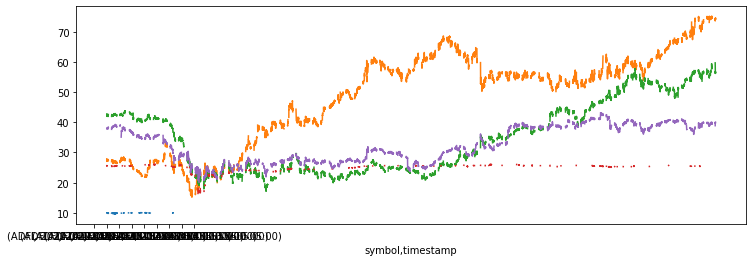

In [89]:
plt.figure(figsize=(12,4))
for symbol in df.index.get_level_values(0).unique():
    df.loc[idx[symbol,:],'open'].plot()

In [ ]:
for symbol in df.index.get_level_values('symbol').unique():
    plt.figure(figsize=(12,4))
    df.loc[idx[symbol,:],'close'].plot()
    plt.xticks(rotation=75)
    plt.show()

In [ ]:
df.loc[idx['TMAT',:],:].head(60)

In [ ]:
df.loc[idx['TMAT',:],:].describe()

In [ ]:
df.loc[idx['AROC',:],:].describe()

In [ ]:
print(df.loc[idx['AROC',:],:])

In [ ]:
api.get_barset(assets_query[:1], '15Min',
                                  start=pd.Timestamp("2020-01-01").isoformat(),
#                                   start=start_date_dt,
#                                   end=pd.Timestamp(end_date).isoformat(),
                                  limit=100).df.droplevel(0,axis=1)

In [ ]:
# Resample and return Open. High, Low, Close
# df.loc[idx[assets_query[0],:]].resample("1D")['open'].ohlc().iloc[:4]
df.loc[idx[test_list[3],:]].resample("1D")['open'].ohlc().iloc[:4]

In [ ]:
import alpaca_backtrader_api
import backtrader as bt
# from datetime import datetime

# ALPACA_API_KEY = <key_id>
# ALPACA_SECRET_KEY = <secret_key>
# ALPACA_PAPER = True


class SmaCross(bt.SignalStrategy):
  def __init__(self):
    sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
    crossover = bt.ind.CrossOver(sma1, sma2)
    self.signal_add(bt.SIGNAL_LONG, crossover)


cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

In [ ]:
store = alpaca_backtrader_api.AlpacaStore(
#     key_id=ALPACA_API_KEY,
#     secret_key=ALPACA_SECRET_KEY,
#     paper=ALPACA_PAPER
)

In [ ]:
if not ALPACA_PAPER:
  broker = store.getbroker()  # or just alpaca_backtrader_api.AlpacaBroker()
  cerebro.setbroker(broker)

In [ ]:
DataFactory = store.getdata  # or use alpaca_backtrader_api.AlpacaData
data0 = DataFactory(dataname='AAPL', historical=True, fromdate=datetime(
    2015, 1, 1), timeframe=bt.TimeFrame.Days)
cerebro.adddata(data0)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()

## Add Technical indicators
normalized volume?

### Technical Indicator functions

In [ ]:
df.columns

In [ ]:
def log_return(df, OHLC='close', bars=1):
    np.log(df[OHLC]/data.shift(bars))
    
    

In [ ]:
class Moneyflow_Volume_5d(CustomFactor):
    inputs = [USEquityPricing.close, USEquityPricing.volume]
    window_length = 5
    def compute(self, today, assets, out, close, volume):
        mfvs = []
        for col_c, col_v in zip(close.T, volume.T):
            # denominator
            denominator = np.dot(col_c, col_v)
            # numerator
            numerator = 0.
            for n, price in enumerate(col_c.tolist()):
                if price > col_c[n - 1]:
                    numerator += price * col_v[n]
                else:
                    numerator -= price * col_v[n]
            mfvs.append(numerator / denominator)
        out[:] = mfvs

In [ ]:
def Price_Momentum_3M():
    return Returns(window_length=63)



def Returns_39W():
    return Returns(window_length=215)


# ### Volatility

# In[9]:


class Vol_3M(CustomFactor):
    # 3 months volatility
    inputs = [Returns(window_length=2)]
    window_length = 63

    def compute(self, today, assets, out, rets):
        out[:] = np.nanstd(rets, axis=0)


# ### Mean Reversion

# In[10]:


class Mean_Reversion_1M(CustomFactor):
    # standardized difference between latest monthly return
    # and their annual average 
    inputs = [Returns(window_length=21)]
    window_length = 252

    def compute(self, today, assets, out, monthly_rets):
        out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) /                  np.nanstd(monthly_rets, axis=0)


# ### Money Flow Volume

# In[11]:


class Moneyflow_Volume_5d(CustomFactor):
    inputs = [USEquityPricing.close, USEquityPricing.volume]
    window_length = 5

    def compute(self, today, assets, out, close, volume):

        mfvs = []

        for col_c, col_v in zip(close.T, volume.T):

            # denominator
            denominator = np.dot(col_c, col_v)

            # numerator
            numerator = 0.
            for n, price in enumerate(col_c.tolist()):
                if price > col_c[n - 1]:
                    numerator += price * col_v[n]
                else:
                    numerator -= price * col_v[n]

            mfvs.append(numerator / denominator)
        out[:] = mfvs


# ### Price Trend

# A linear price trend that we estimate using linear regression (see [Chapter 7](../../07_linear_models) works as follows: we use the 252 latest close prices to compute the regression coefficient on a linear time trend:

# In[12]:


class Trendline(CustomFactor):
    # linear 12 month price trend regression
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        X = np.arange(self.window_length).reshape(-1, 1).astype(float)
        X -= X.mean()
        Y = close - np.nanmean(close, axis=0)
        out[:] = (X.T @ Y / np.var(X)) / self.window_length


# ### Price Oscillator

# In[13]:


class Price_Oscillator(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        four_week_period = close[-20:]
        out[:] = (np.nanmean(four_week_period, axis=0) /
                  np.nanmean(close, axis=0)) - 1.

In [ ]:
vol_3M = Vol_3M()
mean_reversion_1M = Mean_Reversion_1M()
macd_signal_10d = MACDSignal()
moneyflow_volume_5d = Moneyflow_Volume_5d()
trendline = Trendline()
price_oscillator = Price_Oscillator()
price_momentum_3M = Price_Momentum_3M()
returns_39W = Returns_39W()
true_range = TrueRange()


# In[15]:


features = {
    'Vol 3M'             : vol_3M,
    'Mean Reversion 1M'  : mean_reversion_1M,
    'MACD Signal 10d'    : macd_signal_10d,
    'Moneyflow Volume 5D': moneyflow_volume_5d,
    'Trendline'          : trendline,
    'Price Oscillator'   : price_oscillator,
    'Price Momentum 3M'  : price_momentum_3M,
    '39 Week Returns'    : returns_39W,
    'True Range'         : true_range
}


### Define asset Universe

In [ ]:
def make_universe():
    # Set screen
    dollar_volume = AverageDollarVolume(window_length=90)
    return dollar_volume.top(UNIVERSE)


# In[19]:


universe = make_universe()

### Apply technical indicators with Pipeline

In [ ]:
def make_ml_pipeline(universe, window_length=21, n_forward_days=5):
    pipeline_columns = OrderedDict()

    # ensure that returns is the first input
    pipeline_columns['Returns'] = Returns(inputs=[USEquityPricing.open],
                                          mask=universe,
                                          window_length=n_forward_days + 1)

    # convert factors to ranks; append to pipeline
    pipeline_columns.update({k: v.rank(mask=universe)
                             for k, v in features.items()})

    # Create ML pipeline factor.
    # window_length = length of the training period
    pipeline_columns['predictions'] = LinearModel(inputs=pipeline_columns.values(),
                                         window_length=window_length + n_forward_days,
                                         mask=universe)

    return Pipeline(screen=universe, columns=pipeline_columns)

In [ ]:
    ml_pipeline = make_ml_pipeline(universe,
                                   n_forward_days=N_FORWARD_DAYS,
                                   window_length=TRAINING_PERIOD)

## Cluster Price Movement
volume trends?

# SCRAP - SCRAP - SCRAP

In [ ]:
def build_local_db_from_alpaca()
for symbol in symbols:
    start_date = datetime(2020, 1, 6).date()
    end_date_range = datetime(2020, 11, 20).date()

    while start_date < end_date_range:
        end_date = start_date + timedelta(days=4)

        print(f"== Fetching minute bars for {symbol} {start_date} - {end_date} ==")
        minutes = api.polygon.historic_agg_v2(symbol, 1, 'minute', _from=start_date, to=end_date).df
        minutes = minutes.resample('1min').ffill()

        for index, row in minutes.iterrows():
            cursor.execute("""
                INSERT INTO stock_price_minute (stock_id, datetime, open, high, low, close, volume)
                VALUES (?, ?, ?, ?, ?, ?, ?)
            """, (stock_ids[symbol], index.tz_localize(None).isoformat(), row['open'], row['high'], row['low'], row['close'], row['volume']))

        start_date = start_date + timedelta(days=7)

In [ ]:
# import config
import sqlite3
import pandas
import csv
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, time

In [ ]:
connection = sqlite3.connect(config.DB_FILE)
connection.row_factory = sqlite3.Row

cursor = connection.cursor()

api = tradeapi.REST(config.API_KEY, config.SECRET_KEY, config.API_URL)
symbols = []
stock_ids = {}

with open('qqq.csv') as f:
    reader = csv.reader(f)

    for line in reader:
        symbols.append(line[1])

cursor.execute("""
    SELECT * FROM stock
""")

stocks = cursor.fetchall()

for stock in stocks:
    symbol = stock['symbol']
    stock_ids[symbol] = stock['id']
    
for symbol in symbols:
    start_date = datetime(2020, 1, 6).date()
    end_date_range = datetime(2020, 11, 20).date()

    while start_date < end_date_range:
        end_date = start_date + timedelta(days=4)

        print(f"== Fetching minute bars for {symbol} {start_date} - {end_date} ==")
        minutes = api.polygon.historic_agg_v2(symbol, 1, 'minute', _from=start_date, to=end_date).df
        minutes = minutes.resample('1min').ffill()

        for index, row in minutes.iterrows():
            cursor.execute("""
                INSERT INTO stock_price_minute (stock_id, datetime, open, high, low, close, volume)
                VALUES (?, ?, ?, ?, ?, ?, ?)
            """, (stock_ids[symbol], index.tz_localize(None).isoformat(), row['open'], row['high'], row['low'], row['close'], row['volume']))

        start_date = start_date + timedelta(days=7)

connection.commit()

In [ ]:
start_date = '2021-01-01'
end_date = '2021-05-25'
minutes = api.polygon.historic_agg_v2('AEO', 1, 'minute', _from=start_date, to=end_date).df
minutes = minutes.resample('1min').ffill()

In [ ]:
assets.df

In [ ]:
%%time
# symbol = 'SPY'
def build_multi_symbol_df(assets,start_date = '2021-01-01',end_date = '2021-05-25'):
    """Queries multiple symbols stored in assets and return a single multi-index dataframe"""
# start_date = '2021-01-01'
# end_date = '2021-05-25'
# limit = 200
    columns = list(api.get_bars(assets[0], TimeFrame.Hour,
            start='2021-01-01', end='2021-01-20', adjustment='raw').df.columns)
    temp = pd.DataFrame(columns=['symbol',
             'timestamp'] + columns).set_index(['symbol','timestamp'])
    bars_ = []
    for symbol in assets:
        bars = api.get_bars(symbol, TimeFrame.Hour, start=start_date, end=end_date, adjustment='raw').df
#         in case there 
        bars = bars.resample('H').ffill()
        idx_tuples = [(symbol,timestamp) for timestamp in bars.index]
        bars.set_index(pd.Index(idx_tuples), inplace=True)
        bars.rename_axis(['symbol','timestamp'], inplace=True)
        bars_.append(bars)
    return pd.concat([temp] + bars_)
    del bars_
    
df =  build_multi_symbol_df(assets_query, start_date = '2021-01-01',end_date = '2021-05-25')
df.info()

In [ ]:
def build_multi_symbol_df(assets,start_date = '2021-01-01', end_date = '2021-05-25',
                          max_days_chunk=30):
    """Queries multiple symbols stored in assets as list and return a single 
    multi-index dataframe"""
    # Get Name of columns for temp df
    n_assets = len(assets)
    print(f'{n_assets} total assets to query')
    columns = list(api.get_bars(assets[0], TimeFrame.Hour,
            start='2021-01-01', end='2021-01-20', adjustment='raw').df.columns)
    temp = pd.DataFrame(columns=['symbol',
             'timestamp'] + columns).set_index(['symbol','timestamp'])
    bars_ = []
    end_date_range = datetime.strptime(end_date,"%Y-%m-%d")
#     start_date_dt = datetime.strptime(start_date,"%Y-%m-%d")
    for idx, symbol in enumerate(assets):
        
#         reset start_date_dt
        start_date_dt = datetime.strptime(start_date,"%Y-%m-%d")
        print(f'== {idx} of {n_assets} querying {symbol} from {start_date} to {end_date} ==')
#         limit date range to not exceed API's bars limit
        while start_date_dt < end_date_range:
            start_date_str = datetime.strftime(start_date_dt, "%Y-%m-%d")
#             end of date range based on chunk size:
            chunk_end_date = start_date_dt + timedelta(days=max_days_chunk)
#           check if chunk_end_date occurs after defined end_date_range
            end_date_dt = min(chunk_end_date, end_date_range)
            end_date = datetime.strftime(end_date_dt,"%Y-%m-%d")
            print(f"== Fetching bars for {symbol} {start_date_str} - {end_date} ==")
            bars = api.get_bars(symbol, TimeFrame.Hour, start=start_date_str, end=end_date,
                                adjustment='raw').df
#     #         in case the time-series is incomplete, fill gaps (this adds copied rows..)
#             bars = bars.resample('H').ffill()
            idx_tuples = [(symbol,timestamp) for timestamp in bars.index]
            bars.set_index(pd.Index(idx_tuples), inplace=True)
            bars.rename_axis(['symbol','timestamp'], inplace=True)
            bars_.append(bars)
#             Reset start date to the start of next chunk
            start_date_dt = datetime.strptime(end_date,"%Y-%m-%d") + timedelta(days=1)
#             start_date_dt = datetime.strptime(next_start_date, "%Y-%m-%d")
            start_date_str = datetime.strftime(start_date_dt, "%Y-%m-%d")
    df = pd.concat([temp] + bars_)
    if 'volume' in df.columns:
        df['volume'] = df['volume'].astype('int')
#     df.index = df.index.tz_convert('America/New_York')
    return df
    del bars_, df
    

In [ ]:
api.get_aggs(assets_query[0], _from= '2019-01-01', to= '2021-05-25', multiplier=1, timespan = 'day').df

In [ ]:
api.get_barset(assets_query[:2], start = '2019-01-01', end= '2021-05-25', timeframe='1D')

In [ ]:
columns = list(api.get_barset(assets_query[0], '1D',
        start="2021-01-01", end="2021-01-02").df.droplevel(0,axis=1).columns)
# bars.droplevel(0,axis=1)
temp = pd.DataFrame(columns=['symbol',
         'timestamp'] + columns).set_index(['symbol','timestamp'])

In [ ]:
columns

In [ ]:
temp

In [ ]:
def alpaca_configuration():
    """Returns alpaca_config dictionary containing parameters for connection and
    data requests by soliciting user inputs."""
#     TWS_or_gateway = int(input('Connect to IB through TWS (0) or Gateway (1)? :'))
#     trading_mode = int(input('Live (0) or Paper (1) trading mode? :'))
#     instrument_list = ("STK", "OPT", "FUT", "IND", "FOP", "CASH", "BAG", "WAR",
#                        "BOND", "CMDTY", "NEWS", "FUND")
#     instrument = str(input('Which instrument {}? :'.format(instrument_list))).upper()
    # Define data frequency using IB 'barSizeSetting' format.  This will also define the filepath
# barSizeSetting
    data_frequencies = ["1 secs","5 secs","10 secs","15 secs","30 secs","1 min","2 mins",
                        "3 mins","5 mins","10 mins","15 mins","20 mins","30 mins","1 hour",
                        "2 hours","3 hours","4 hours","8 hours","1 day","1 week","1 month"]
    data_frequency = str(input('Data frequency {}:'.format(data_frequencies)))
    
#     https://ib-insync.readthedocs.io/api.html?highlight=reqhistorical#ib_insync.client.Client.reqHistoricalData
    whatToShow_list = ('TRADES', 'MIDPOINT', 'BID', 'ASK', 'BID_ASK', 'ADJUSTED_LAST', 'HISTORICAL_VOLATILITY', 'OPTION_IMPLIED_VOLATILITY', 'REBATE_RATE', 'FEE_RATE', 'YIELD_BID', 'YIELD_ASK', 'YIELD_BID_ASK', 'YIELD_LAST')
    whatToShow_enum = list(enumerate(whatToShow_list, start=1))
    wts_idx = int(input('Input index # of value type to be queried for instrument: {}'.format(whatToShow_enum)))
    whatToShow = whatToShow_list[wts_idx]
#     whatToShow = str(input('What value from instrument should be requested? {}:'.format(whatToShow_list)))
    data_duration = '6 M'
    trading_modes = ["Live","Paper"]
    TWS_or_gateway_list = ["TWS", "gateway"]
    ticker_list_dir = 'C:/Users/user/OneDrive/STOCKS/TICKER_HISTORIC_FILES/Python_Data/ticker_lists/'
    ticker_lists_paths = {key:ticker_list_dir + key for key in instrument_list}
    data_output_root = "C:/Users/user/OneDrive/STOCKS/TICKER_HISTORIC_FILES/Python_Data/"

    ib_config = {"TWS_or_gateway": TWS_or_gateway_list[TWS_or_gateway], 
                "trading_mode": trading_modes[trading_mode],
                        "trading_modes": trading_modes,
                        "instrument": instrument,
                       "instruments": instrument_list,
                       'ticker_list_paths': ticker_lists_paths,
                "data_frequency": data_frequency,
                "data_duration": data_duration,
                "whatToShow": whatToShow,
                "data_output_root": data_output_root}

    #define list of tickers to pull based on list in CSV, column header of list must be 'Symbol'
#     ticker_list_csv = pd.read_csv(ib_config['ticker_list_paths'][instrument] + '\\ticker_list.csv')
    ticker_list_csv = pd.read_csv(ib_config['ticker_list_paths'][instrument] + '/ticker_list.csv')
    # ticker_list_csv = pd.read_csv(ticker_list_name)
    ticker_list = ticker_list_csv.Symbol.tolist()
    ib_config["ticker_list"] = ticker_list
    print('\n IB is configured for: \n {} trading \n {} connection \n {} {} frequency'.format(
        ib_config["trading_mode"], ib_config["TWS_or_gateway"], ib_config["instrument"],
        ib_config["data_frequency"]))
    return alpaca_config

In [ ]:
bars = api.get_barset('TMAT', '1D',
                      end='2021-05-03T00:00:00-05:00',
                      limit=1000).df.droplevel(0,axis=1)
bars.index[0], bars.index[-1]

In [ ]:
bars.loc['2019-01':]

In [ ]:
bars = api.get_barset('GOOG', '15Min',
                      end='2021-03-03T00:00:00-05:00',
                      limit=1000).df.droplevel(0,axis=1)
bars.index[0], bars.index[-1]

In [ ]:
bars = api.get_barset('GOOG', '15Min',
                      end=pd.Timestamp('2021-03-03', tz=TZ).isoformat(),
                      limit=1000).df.droplevel(0,axis=1)
bars.index[0], bars.index[-1]

In [ ]:
bars = api.get_barset('GOOG', '15Min',
                      end=pd.Timestamp('2021-03-03').isoformat(),
#                                   end=pd.Timestamp(end_date_dt).isoformat(),
#                       end='2021-03-03T00:00:00-05:00',
                      limit=1000).df.droplevel(0,axis=1)
bars.index[0], bars.index[-1]

In [ ]:
bars = api.get_barset('BBUS', '15Min',
                      end=pd.Timestamp('2021-05-25').isoformat(),
#                                   end=pd.Timestamp(end_date_dt).isoformat(),
#                       end='2021-03-03T00:00:00-05:00',
                      limit=1000).df.droplevel(0,axis=1)
bars.index[0], bars.index[-1]

In [ ]:
bars

In [ ]:
bars = api.get_barset('BBUS', '15Min',
                      end=pd.Timestamp('2021-05-25', tz=TZ).isoformat(),
#                                   end=pd.Timestamp(end_date_dt).isoformat(),
#                       end='2021-03-03T00:00:00-05:00',
                      limit=1000).df.droplevel(0,axis=1)
print(f'Start of barset index {bars.index[0]}')
print(f'End of barset index {bars.index[-1]}')

In [ ]:
pd.Timestamp('2021-03-03', tz=TZ,).isoformat()

In [ ]:
pd.Timestamp('2021-03-03').isoformat()

In [ ]:
# NEW 6-26-21
def build_multi_symbol_df(assets,start_date = '2021-01-01', end_date = '2021-05-25',
                          max_days_chunk=30, frequency='15Min', limit=1000, TZ = 'America/New_York'):
    """Queries multiple symbols stored in assets as list and return a single 
    multi-index dataframe.   Relies on Alpaca's .get_barset() function.  This function divides large
    queries in to chunks and starts the first query chunk at the 'end_date' and works backward in time
    by requesting the max 'limit' of 1000 bars.  After each chunk query completes, the first bar of 
    the previous query chunk becomes the "end_date" of the next query chunk.
    Day = "1Day"
    Hour = "1Hour"
    Minute = "1Min"
    Sec = "1Sec"
    """
    # Get Name of columns for temp df
    n_assets = len(assets)
    print(f'{n_assets} total assets to query')
    start_date_plus_1 = datetime.strftime(datetime.strptime(start_date,"%Y-%m-%d") + timedelta(days=10),"%Y-%m-%d" )
#     columns = list(api.get_barset(assets[0], frequency,
#             start=start_date, end=start_date_plus_1).df.columns)
# Define columns for output df
    columns = list(api.get_barset(assets[0], frequency,
        start=start_date, end=start_date_plus_1).df.droplevel(0,axis=1).columns)
#     build empty df to hold barset results
    temp = pd.DataFrame(columns=['symbol',
             'timestamp'] + columns).set_index(['symbol','timestamp'])
#     global bars_
#     create bars_ variable to hold iterative/chunk bars query results
    bars_ = []
    # set last date of overall query in time-zone aware datetime format 
#     final_end_date_dt = datetime.strptime(end_date,"%Y-%m-%d")
    global final_end_date_dt
    final_end_date_str = pd.Timestamp(end_date, tz=TZ).isoformat()
    final_start_date_str = pd.Timestamp(start_date, tz=TZ).isoformat()
#     final_end_date_dt = datetime.strptime(final_end_date_str,"%Y-%m-%d")
    final_end_date_dt = pd.Timestamp(end_date, tz=TZ).to_pydatetime()
#     final_start_date_dt = datetime.strptime(final_start_date_str,"%Y-%m-%d")
    final_start_date_dt = pd.Timestamp(start_date, tz=TZ).to_pydatetime()
#     start_date_dt = datetime.strptime(start_date,"%Y-%m-%d")
    for idx, symbol in enumerate(assets):
#         reset start_date_dt
        start_date_dt = datetime.strptime(start_date,"%Y-%m-%d")
#         print(f'== {idx} of {n_assets} querying {symbol} from {start_date} to {end_date} ==')
        print(f'== {idx} of {n_assets} querying {symbol} from {end_date} ==')
#         limit date range to not exceed API's bars limit
#         while start_date_dt < final_end_date_dt:
        chunk_start_date_dt = final_end_date_dt
        while final_start_date_dt < chunk_start_date_dt:
#             start_date_str = datetime.strftime(start_date_dt, "%Y-%m-%d")
            
#             end of date range based on chunk size:
#             chunk_end_date = start_date_dt + timedelta(days=max_days_chunk)
#             chunk_end_date = start_date_dt + timedelta(days=max_days_chunk)
#             print(chunk_end_date)
            print(chunk_start_date_dt)
#           check if chunk_end_date occurs after defined final_end_date_dt
#             end_date_dt = min(chunk_end_date, final_end_date_dt)
#             end_date = datetime.strftime(end_date_dt,"%Y-%m-%d")
            end_date_str = datetime.strftime(chunk_start_date_dt,"%Y-%m-%d")
#             print(f"== Fetching bars for {symbol} from {end_date_str} back {limit} bars ==")
            print(f"== Fetching bars for {symbol} from {end_date_str} back {limit} bars ==")
#             bars = api.get_bars(symbol, TimeFrame.Hour, start=start_date_str, end=end_date,
#                                 adjustment='raw').df
#             bars = api.get_barset(symbol, frequency, start=start_date_str, end=end_date).df
#             print(start_date_str, " to " , end_date)
#     api.get_barset() is ignoring all date inputs - 
# there is no control over start/end dates regardless of input
            bars = api.get_barset(symbol, frequency, end=end_date_str, limit=limit).df.droplevel(0,axis=1)
#     #         in case the time-series is incomplete, fill gaps (this adds copied rows..)
#             bars = bars.resample('H').ffill()
            idx_tuples = [(symbol,timestamp) for timestamp in bars.index]
            bars.set_index(pd.Index(idx_tuples), inplace=True)
            bars.rename_axis(['symbol','timestamp'], inplace=True)
            bars_.append(bars)
#             Reset chunk end date to be the start of the last chunk that was queried
            chunk_start_date_dt = bars.index[0][1]
#             start_date_dt = datetime.strptime(end_date,"%Y-%m-%d") + timedelta(days=1)
#             start_date_dt = datetime.strptime(next_start_date, "%Y-%m-%d")
#             start_date_str = datetime.strftime(start_date_dt, "%Y-%m-%d")
        
    df = pd.concat([temp] + bars_)
    if 'volume' in df.columns:
        df['volume'] = df['volume'].astype('int')
#     df.index = df.index.tz_convert('America/New_York')
    return df
    del bars_, df
df_dev = build_multi_symbol_df(assets_query[:2],start_date = '2021-01-01', end_date = '2021-05-25',
                          max_days_chunk=30, frequency='1D', limit=1000)

### Simple CHunk query

In [ ]:
end = pd.Timestamp('2020-10-26 10:00:00-04:00', tz=TZ)
end.to_pydatetime().isoformat()

In [ ]:
date_ranges = [(pd.Timestamp('2020-10-26 10:00:00-04:00').isoformat(),pd.Timestamp('2020-11-26 10:00:00-04:00').isoformat()),
              (pd.Timestamp('2020-11-27 10:00:00-04:00').isoformat(),pd.Timestamp('2020-12-26 10:00:00-04:00').isoformat())]

In [ ]:
date_ranges

In [ ]:
for rng in date_ranges:
#     display(api.get_barset('GOOG','15Min',start=rng[0], end=rng[-1]).df)
    display(api.get_barset('GOOG','15Min',end=rng[-1]).df)

In [ ]:
# NEW 6-19-21
def build_multi_symbol_df(assets,start_date = '2021-01-01', end_date = '2021-05-25',
                          max_days_chunk=30, frequency='1D', TZ = 'America/New_York'):
    """Queries multiple symbols stored in assets as list and return a single 
    multi-index dataframe
    Day = "1Day"
    Hour = "1Hour"
    Minute = "1Min"
    Sec = "1Sec"
    """
    
    # Get Name of columns for temp df
    n_assets = len(assets)
    print(f'{n_assets} total assets to query')
#     columns = list(api.get_bars(assets[0], TimeFrame.Hour,
#             start='2021-01-01', end='2021-01-20', adjustment='raw').df.columns)
    start_date_plus_1 = datetime.strftime(datetime.strptime(start_date,"%Y-%m-%d") + timedelta(days=10),"%Y-%m-%d" )
#     columns = list(api.get_barset(assets[0], frequency,
#             start=start_date, end=start_date_plus_1).df.columns)
    columns = list(api.get_barset(assets[0], frequency,
        start=start_date, end=start_date_plus_1).df.droplevel(0,axis=1).columns)
    temp = pd.DataFrame(columns=['symbol',
             'timestamp'] + columns).set_index(['symbol','timestamp'])
    global bars_
    bars_ = []
    end_date_range = datetime.strptime(end_date,"%Y-%m-%d")
#     start_date_dt = datetime.strptime(start_date,"%Y-%m-%d")
    for idx, symbol in enumerate(assets):
        
#         reset start_date_dt
        start_date_dt = datetime.strptime(start_date,"%Y-%m-%d")
        print(f'== {idx} of {n_assets} querying {symbol} from {start_date} to {end_date} ==')
#         limit date range to not exceed API's bars limit
        while start_date_dt < end_date_range:
            start_date_str = datetime.strftime(start_date_dt, "%Y-%m-%d")
            
#             end of date range based on chunk size:
            chunk_end_date = start_date_dt + timedelta(days=max_days_chunk)
            print(chunk_end_date)
#           check if chunk_end_date occurs after defined end_date_range
            end_date_dt = min(chunk_end_date, end_date_range)
            end_date = datetime.strftime(end_date_dt,"%Y-%m-%d")
            print(f"== Fetching bars for {symbol} {start_date_str} - {end_date} ==")
#             bars = api.get_bars(symbol, TimeFrame.Hour, start=start_date_str, end=end_date,
#                                 adjustment='raw').df
#             bars = api.get_barset(symbol, frequency, start=start_date_str, end=end_date).df
            print(start_date_str, " to " , end_date)
#     api.get_barset() is ignoring all date inputs - 
# there is no control over start/end dates regardless of input

#             bars = api.get_barset(symbol, frequency, start=start_date_str,
#                                   end=end_date).df.droplevel(0,axis=1)
#             pd.Timestamp(bar.df.index[0]).isoformat()
            bars = api.get_barset(symbol, frequency, start=pd.Timestamp(start_date_str).isoformat(),
                                  end=pd.Timestamp(end_date).isoformat()).df.droplevel(0,axis=1)
#     #         in case the time-series is incomplete, fill gaps (this adds copied rows..)
#             bars = bars.resample('H').ffill()
            idx_tuples = [(symbol,timestamp) for timestamp in bars.index]
            bars.set_index(pd.Index(idx_tuples), inplace=True)
            bars.rename_axis(['symbol','timestamp'], inplace=True)
            bars_.append(bars)
#             Reset start date to the start of next chunk
            start_date_dt = datetime.strptime(end_date,"%Y-%m-%d") + timedelta(days=1)
#             start_date_dt = datetime.strptime(next_start_date, "%Y-%m-%d")
            start_date_str = datetime.strftime(start_date_dt, "%Y-%m-%d")
        
    df = pd.concat([temp] + bars_)
    if 'volume' in df.columns:
        df['volume'] = df['volume'].astype('int')
#     df.index = df.index.tz_convert('America/New_York')
    return df
    del bars_, df
    

In [ ]:
df = build_multi_symbol_df(assets_query[:2],start_date = '2021-01-01', end_date = '2021-05-25',
                          max_days_chunk=30, frequency='1D')

In [ ]:
df

In [ ]:
idx = pd.IndexSlice
plt.figure(figsize=(14,4))
df.loc[idx[assets_query[0],:],'high'].plot()

#### Alpaca get_barset returning data outside of specified date range!

In [ ]:
# api.get_barset(assets_query[:2], timeframe='1D', start="2020-01-01", end="2020-05-12").df
api.get_barset(assets_query[:2], timeframe='1D', start="2020-01-01", limit=1000, end="2020-01-01").df.droplevel(0,axis=1)

In [ ]:
TZ = 'America/New_York'

# api = tradeapi.REST()
# api = tradeapi.REST( alpacaApiKey, alpacaSecretKey )
# beg = pd.Timestamp('2021-02-02T09:30', tz=TZ).isoformat()
beg = pd.Timestamp('2021-01-02T09:30', tz=TZ).isoformat()
# end = pd.Timestamp('2021-02-02T16:00', tz=TZ).isoformat()
end = pd.Timestamp('2021-03-02T16:00', tz=TZ).isoformat()
# bar = api.get_barset(['GOOG'], '5Min', start=beg, end=end)
bar = api.get_barset(['GOOG'], '5Min', start=beg, end=end,limit=1000)

print(bar.df.index.sort_values()[0])

In [ ]:
bar.df.info()

In [ ]:
df =  build_multi_symbol_df(assets_query[:2], start_date = '2019-01-01',end_date = '2021-05-25')
df.info()

In [ ]:
idx=pd.IndexSlice
df.loc[idx[assets_query[0],:]].describe().loc[['min','std','max','count']]

In [ ]:
# pd.date_range()
print('Shape of df for each asset')
df.loc[idx[assets_query[0],:]].shape

### Time comparison of query methods
chunked queries vs barset query

In [ ]:
start_date = '2020-01-01'
end_date = '2020-12-31'

start_time = timeit.default_timer()
df_chunked =  build_multi_symbol_df(assets_query[:1], start_date = start_date,end_date = end_date, max_days_chunk=180)
print(timeit.default_timer() - start_time)

# start_time = timeit.default_timer()
# df_barset = api.get_bars(assets_query[0], TimeFrame.Hour,
#             start=start_date, end=end_date, adjustment='raw').df
# print(timeit.default_timer() - start_time)

In [ ]:
# df_chunked.info()

In [ ]:
# df_barset.info()

#### Plot data

In [ ]:
df_dev

In [ ]:
df_dev.loc[idx[assets_query[0],:],'high'].shape

In [ ]:
TZ = 'America/New_York'

# api = tradeapi.REST()
# api = tradeapi.REST( alpacaApiKey, alpacaSecretKey )
# beg = pd.Timestamp('2021-02-02T09:30', tz=TZ).isoformat()
beg = pd.Timestamp('2021-01-02T09:30', tz=TZ).isoformat()
# end = pd.Timestamp('2021-02-02T16:00', tz=TZ).isoformat()
end = pd.Timestamp('2021-03-02T16:00', tz=TZ).isoformat()
# bar = api.get_barset(['GOOG'], '5Min', start=beg, end=end)
# bar = api.get_barset(['GOOG'], '5Min', start=beg, end=end,limit=1000)
bar = api.get_barset(['GOOG'], '5Min', end=end,limit=1000)
print(beg, end)
print(bar.df.index[0])
print(bar.df.index[-1])

In [ ]:
# end = pd.Timestamp('2021-02-02T16:00', tz=TZ).isoformat()
# end = pd.Timestamp('2021-03-02T16:00', tz=TZ).isoformat()
end = pd.Timestamp('2021-03-03', tz=TZ).isoformat()
bar = api.get_barset(['GOOG'], '5Min', end=end,limit=1000)
print(end)
print(bar.df.index[0])
print(bar.df.index[-1])

In [ ]:
pd.Timestamp(bar.df.index[0]).isoformat()
# pd.Timestamp(bar.df.index[0],tz=TZ).tz_convert()
# datetime.

In [ ]:
type(bar.df.index[0])

In [ ]:
pd.Timestamp('2020-10-26 10:00:00-04:00')

In [ ]:
# print(bar.df.index[10])
# start = bar.df.index[10]
end = pd.Timestamp('2020-10-26 10:00:00-04:00', tz=TZ)
print(start)
# bar = api.get_barset('GOOG', '5Min', end=pd.Timestamp(bar.df.index[10]).isoformat(),limit=1000)
bar = api.get_barset(['GOOG'], '5Min', end=pd.Timestamp(end).isoformat(),limit=1000)
bar.df.index

In [ ]:
# end = pd.Timestamp('2020-10-26 10:00:00-04:00', tz=TZ)
# print(start)
print(pd.Timestamp(end).isoformat())
print(bar.df.index[0].isoformat())
# bar = api.get_barset('GOOG', '5Min', end=pd.Timestamp(bar.df.index[10]).isoformat(),limit=1000)
bar = api.get_barset(['GOOG'], '5Min', end=bar.df.index[0].isoformat(),limit=1000)
bar.df.index

In [ ]:
bar = api.get_barset(['GOOG'], '5Min', end=bar.df.index[0].isoformat(),limit=1000)
bar.df.index

In [ ]:
# bar = api.get_barset(['GOOG'], '5Min', start=pd.Timestamp(bar.df.index[10]).isoformat(),
#                      end=pd.Timestamp(bar.df.index[20]).isoformat(),limit=1000)
# bar.df.index

In [ ]:
pd.Timestamp('2021-01-02', tz=TZ).isoformat()

In [ ]:
pd.to_datetime(pd.Timestamp('2021-01-02', tz=TZ).isoformat())

In [ ]:
pd.Timestamp('2021-01-02', tz=TZ).to_pydatetime()

In [150]:
# bars.iloc[:20]

In [140]:
TZ = 'America/New_York'
bars = api.get_barset('AAQC.U', '5Min',
                          end=pd.Timestamp('2021-05-19', tz=TZ).isoformat(),
                          limit=1000).df.droplevel(0,axis=1)

In [144]:
pd.options.display.max_rows

60

In [149]:
bars.iloc[-50:]

open    high     low   close  volume
2021-04-15 13:20:00-04:00  10.000  10.000  10.000  10.000   18150
2021-04-15 14:05:00-04:00  10.000  10.000   9.970   9.975    2500
2021-04-15 14:10:00-04:00   9.980   9.980   9.980   9.980    5600
2021-04-15 14:25:00-04:00  10.020  10.020  10.020  10.020     100
2021-04-15 14:30:00-04:00  10.020  10.030  10.020  10.030    1991
2021-04-15 15:45:00-04:00   9.990   9.990   9.990   9.990     339
2021-04-16 12:30:00-04:00  10.000  10.000  10.000  10.000     100
2021-04-16 15:30:00-04:00  10.005  10.005  10.005  10.005     100
2021-04-16 15:55:00-04:00  10.010  10.010  10.010  10.010     100
2021-04-19 10:25:00-04:00  10.020  10.020  10.020  10.020     800
2021-04-19 10:35:00-04:00  10.020  10.020  10.020  10.020     100
2021-04-19 10:55:00-04:00  10.000  10.000  10.000  10.000     100
2021-04-19 14:30:00-04:00   9.990   9.990   9.990   9.990     300
2021-04-19 14:35:00-04:00   9.990   9.990   9.990   9.990     100
2021-04-19 14:40:00-04:00   9.990   9.990   9.990   9.990     100
2021-04-19 15:20:00-04:00   9.990   9.990   9.990   9.990    1400
2021-04-19 15:30:00-04:00  10.000  10.000  10.000  10.000     100
2021-04-19 15:35:00-04:00  10.020  10.020  10.020  10.020     200
2021-04-19 15:40:00-04:00  10.020  10.020  10.020  10.020     100
2021-04-20 11:00:00-04:00   9.980   9.980   9.980   9.980     100
2021-04-20 11:15:00-04:00   9.990   9.990   9.990   9.990     100
2021-04-20 15:05:00-04:00  10.000  10.000  10.000  10.000     210
2021-04-20 15:10:00-04:00  10.010  10.010  10.010  10.010     100
2021-04-20 15:40:00-04:00  10.020  10.020  10.020  10.020     200
2021-04-20 15:45:00-04:00  10.020  10.020  10.020  10.020     100
2021-04-22 14:50:00-04:00   9.960   9.960   9.960   9.960     100
2021-04-22 15:00:00-04:00   9.950   9.950   9.950   9.950     200
2021-04-22 15:30:00-04:00   9.955   9.955   9.955   9.955    1000
2021-04-22 15:35:00-04:00   9.955   9.955   9.955   9.955     300
2021-04-23 14:15:00-04:00   9.920   9.920   9.920   9.920     100
2021-04-23 14:20:00-04:00   9.920   9.920   9.900   9.900    1200
2021-04-23 14:25:00-04:00   9.920   9.930   9.920   9.930     200
2021-04-23 14:30:00-04:00   9.930   9.930   9.930   9.930     200
2021-04-23 14:35:00-04:00   9.930   9.940   9.930   9.940     300
2021-04-23 14:45:00-04:00   9.930   9.930   9.930   9.930     400
2021-04-26 11:45:00-04:00   9.950   9.950   9.950   9.950    2861
2021-04-27 14:40:00-04:00   9.995   9.995   9.995   9.995    1859
2021-05-04 14:40:00-04:00   9.970   9.970   9.970   9.970     352
2021-05-06 13:00:00-04:00   9.970   9.980   9.970   9.970    1500
2021-05-10 12:30:00-04:00   9.960   9.960   9.960   9.960     900
2021-05-10 15:50:00-04:00   9.980   9.980   9.980   9.980     328
2021-05-12 11:25:00-04:00   9.990   9.990   9.990   9.990     100
2021-05-12 11:30:00-04:00   9.990   9.990   9.990   9.990     463
2021-05-12 15:25:00-04:00   9.995   9.995   9.995   9.995     336
2021-05-12 15:35:00-04:00   9.995   9.995   9.995   9.995     100
2021-05-12 15:40:00-04:00   9.995   9.995   9.995   9.995     300
2021-05-12 15:50:00-04:00   9.995   9.995   9.995   9.995     200
2021-05-14 14:20:00-04:00  10.010  10.010  10.010  10.010     600
2021-05-18 12:15:00-04:00  10.000  10.000  10.000  10.000    6200
2021-05-18 15:30:00-04:00  10.000  10.000  10.000  10.000    1026

In [102]:
# df.groupby(pd.Grouper(freq='15Min',level=1)).mean()
df.groupby(pd.Grouper(freq='15Min',level=1)).mean().describe()

open         high          low        close        volume
count  9081.000000  9081.000000  9081.000000  9081.000000  13234.000000
mean     38.074768    37.986158    37.763872    37.875532    819.243577
std       9.153005     9.145965     9.383506     9.222469   1025.439486
min      19.232500    10.693889     0.000000     4.633125    100.583333
25%      30.757500    30.702000    30.505000    30.575000    271.433333
50%      38.211667    38.008125    37.872857    37.907500    461.958333
75%      44.940000    44.783875    44.690000    44.731111    939.170833
max      66.690000    66.690000    66.690000    66.690000  10863.500000

In [104]:
df.groupby(pd.Grouper(freq='10Min',level=1)).mean().describe()

open          high           low         close        volume
count  26391.000000  26391.000000  26391.000000  26391.000000  39702.000000
mean      38.069381     37.976038     37.746244     37.862324    819.273749
std       10.211374     10.259836     10.469785     10.336604   1053.815010
min        9.800000      0.000000      0.000000      0.000000     49.200000
25%       29.713333     29.643333     29.412083     29.541250    254.800000
50%       38.333333     38.205000     38.058333     38.115000    455.000000
75%       45.352917     45.276667     45.154167     45.200833    941.200000
max       75.120000     75.120000     75.120000     75.120000  14580.750000

### Eliminate duplicated indices

In [236]:
def drop_duplicate_dt_from_multiindex(df, duplicated_dt_index):
    symbol_dt_index_duplicated = [k for k in duplicated_dt_index.keys() if duplicated_dt_index[k] ]
    symbol_dt_index_duplicated
    for symbol in symbol_dt_index_duplicated:
        dup_idx = idx[symbol,:]
        print(f'{symbol} has {df.loc[dup_idx].shape[0]} records before duplicate drop')
    #     display(df.loc[dup_idx].drop_duplicates().shape)
#         df.loc[dup_idx] = df.loc[dup_idx].drop_duplicates()
#         df.loc[dup_idx].index = df.loc[dup_idx].index.drop_duplicates()
#         df.loc[dup_idx].index.drop_duplicates(inplace=True)
#         unique_idx = ~df.loc[dup_idx].index.duplicated()
        unique_idx = ~df.loc[dup_idx].index.duplicated(keep='first')
        print(f'{symbol} has {sum(unique_idx)} unique indices')
#         display(df.loc[dup_idx].loc[unique_idx].shape[0])
#         df.loc[idx[symbol_dt_index_duplicated[0],:]][~df.loc[idx[symbol_dt_index_duplicated[0],:]].index.duplicated(keep='first')]
#         df.loc[dup_idx] = df.loc[dup_idx].loc[unique_idx]
        display(df.loc[dup_idx][unique_idx].shape)
        df.loc[dup_idx] = df.loc[dup_idx][unique_idx].copy()
#         df.loc[idx[symbol,:]] = df.loc[idx[symbol,:]][unique_idx].copy()
        print(f'{symbol} has {df.loc[dup_idx].shape[0]} records after duplicate drop')
    return df

#### What do duplicated indices look like?

In [303]:
symbol_dt_index_duplicated[0]

'AHT'

In [304]:
# df.loc[idx[symbol_dt_index_duplicated[0],:]].loc[first_symbol_duplicates]
# df.loc[idx[symbol_dt_index_duplicated[0],:]].loc[first_symbol_duplicates_timestamps]
df.loc[idx[symbol_dt_index_duplicated[0],:]].loc[first_symbol_duplicates_timestamps]

Empty DataFrame
Columns: [open, high, low, close, volume]
Index: []

In [305]:
df.loc[idx[symbol_dt_index_duplicated[0],:]].index

DatetimeIndex(['2021-04-07 15:45:00-04:00', '2021-04-08 09:30:00-04:00',
               '2021-04-08 09:45:00-04:00', '2021-04-08 10:00:00-04:00',
               '2021-04-08 10:15:00-04:00', '2021-04-08 10:30:00-04:00',
               '2021-04-08 10:45:00-04:00', '2021-04-08 11:00:00-04:00',
               '2021-04-08 11:15:00-04:00', '2021-04-08 11:30:00-04:00',
               ...
               '2020-01-31 14:15:00-05:00', '2020-01-31 14:30:00-05:00',
               '2020-01-31 14:45:00-05:00', '2020-01-31 15:00:00-05:00',
               '2020-01-31 15:15:00-05:00', '2020-01-31 15:30:00-05:00',
               '2020-01-31 15:45:00-05:00', '2020-02-03 09:45:00-05:00',
               '2020-02-03 10:00:00-05:00', '2020-02-03 10:15:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='timestamp', length=8528, freq=None)

In [306]:
df.loc[idx[symbol_dt_index_duplicated[0],:]].index.drop_duplicates(keep='first')

DatetimeIndex(['2021-04-07 15:45:00-04:00', '2021-04-08 09:30:00-04:00',
               '2021-04-08 09:45:00-04:00', '2021-04-08 10:00:00-04:00',
               '2021-04-08 10:15:00-04:00', '2021-04-08 10:30:00-04:00',
               '2021-04-08 10:45:00-04:00', '2021-04-08 11:00:00-04:00',
               '2021-04-08 11:15:00-04:00', '2021-04-08 11:30:00-04:00',
               ...
               '2020-01-31 14:15:00-05:00', '2020-01-31 14:30:00-05:00',
               '2020-01-31 14:45:00-05:00', '2020-01-31 15:00:00-05:00',
               '2020-01-31 15:15:00-05:00', '2020-01-31 15:30:00-05:00',
               '2020-01-31 15:45:00-05:00', '2020-02-03 09:45:00-05:00',
               '2020-02-03 10:00:00-05:00', '2020-02-03 10:15:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='timestamp', length=8528, freq=None)

In [307]:
symbol_dt_index_duplicated[0]

'AHT'

In [308]:
df.loc[idx[symbol_dt_index_duplicated[0],]]

open   high    low  close   volume
timestamp                                                     
2021-04-07 15:45:00-04:00  2.615  2.640  2.610  2.620  18328.0
2021-04-08 09:30:00-04:00  2.610  2.610  2.550  2.550   6868.0
2021-04-08 09:45:00-04:00  2.530  2.570  2.515  2.570   4113.0
2021-04-08 10:00:00-04:00  2.565  2.570  2.530  2.540   1500.0
2021-04-08 10:15:00-04:00  2.530  2.540  2.515  2.520   4200.0
...                          ...    ...    ...    ...      ...
2020-01-31 15:30:00-05:00  2.475  2.480  2.470  2.480   8166.0
2020-01-31 15:45:00-05:00  2.470  2.470  2.460  2.460   9873.0
2020-02-03 09:45:00-05:00  2.475  2.485  2.475  2.485    500.0
2020-02-03 10:00:00-05:00  2.485  2.495  2.485  2.495    700.0
2020-02-03 10:15:00-05:00  2.495  2.505  2.495  2.505   1374.0

[8528 rows x 5 columns]

In [309]:
new_idx = df.loc[idx[symbol_dt_index_duplicated[0],:]].index.drop_duplicates()
new_idx

DatetimeIndex(['2021-04-07 15:45:00-04:00', '2021-04-08 09:30:00-04:00',
               '2021-04-08 09:45:00-04:00', '2021-04-08 10:00:00-04:00',
               '2021-04-08 10:15:00-04:00', '2021-04-08 10:30:00-04:00',
               '2021-04-08 10:45:00-04:00', '2021-04-08 11:00:00-04:00',
               '2021-04-08 11:15:00-04:00', '2021-04-08 11:30:00-04:00',
               ...
               '2020-01-31 14:15:00-05:00', '2020-01-31 14:30:00-05:00',
               '2020-01-31 14:45:00-05:00', '2020-01-31 15:00:00-05:00',
               '2020-01-31 15:15:00-05:00', '2020-01-31 15:30:00-05:00',
               '2020-01-31 15:45:00-05:00', '2020-02-03 09:45:00-05:00',
               '2020-02-03 10:00:00-05:00', '2020-02-03 10:15:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='timestamp', length=8528, freq=None)

In [310]:
# df.loc[idx[symbol_dt_index_duplicated[0],:]] = df.loc[idx[symbol_dt_index_duplicated[0],:]][~df.loc[idx[symbol_dt_index_duplicated[0],:]].index.duplicated(keep='first')]
df.loc[idx[symbol_dt_index_duplicated[0],:]][~df.loc[idx[symbol_dt_index_duplicated[0],:]].index.duplicated(keep='first')]

open   high    low  close   volume
timestamp                                                     
2021-04-07 15:45:00-04:00  2.615  2.640  2.610  2.620  18328.0
2021-04-08 09:30:00-04:00  2.610  2.610  2.550  2.550   6868.0
2021-04-08 09:45:00-04:00  2.530  2.570  2.515  2.570   4113.0
2021-04-08 10:00:00-04:00  2.565  2.570  2.530  2.540   1500.0
2021-04-08 10:15:00-04:00  2.530  2.540  2.515  2.520   4200.0
...                          ...    ...    ...    ...      ...
2020-01-31 15:30:00-05:00  2.475  2.480  2.470  2.480   8166.0
2020-01-31 15:45:00-05:00  2.470  2.470  2.460  2.460   9873.0
2020-02-03 09:45:00-05:00  2.475  2.485  2.475  2.485    500.0
2020-02-03 10:00:00-05:00  2.485  2.495  2.485  2.495    700.0
2020-02-03 10:15:00-05:00  2.495  2.505  2.495  2.505   1374.0

[8528 rows x 5 columns]

In [311]:
df.loc[idx[symbol_dt_index_duplicated[0],:]]

open   high    low  close   volume
timestamp                                                     
2021-04-07 15:45:00-04:00  2.615  2.640  2.610  2.620  18328.0
2021-04-08 09:30:00-04:00  2.610  2.610  2.550  2.550   6868.0
2021-04-08 09:45:00-04:00  2.530  2.570  2.515  2.570   4113.0
2021-04-08 10:00:00-04:00  2.565  2.570  2.530  2.540   1500.0
2021-04-08 10:15:00-04:00  2.530  2.540  2.515  2.520   4200.0
...                          ...    ...    ...    ...      ...
2020-01-31 15:30:00-05:00  2.475  2.480  2.470  2.480   8166.0
2020-01-31 15:45:00-05:00  2.470  2.470  2.460  2.460   9873.0
2020-02-03 09:45:00-05:00  2.475  2.485  2.475  2.485    500.0
2020-02-03 10:00:00-05:00  2.485  2.495  2.485  2.495    700.0
2020-02-03 10:15:00-05:00  2.495  2.505  2.495  2.505   1374.0

[8528 rows x 5 columns]

In [312]:
~df.loc[idx[symbol_dt_index_duplicated[0],]].index.duplicated()

array([ True,  True,  True, ...,  True,  True,  True])

In [198]:
df.loc[idx[symbol_dt_index_duplicated[0],]]

open  high  low  close  volume
timestamp                                                
2021-04-07 15:45:00-04:00   NaN   NaN  NaN    NaN     NaN
2021-04-08 09:30:00-04:00   NaN   NaN  NaN    NaN     NaN
2021-04-08 09:45:00-04:00   NaN   NaN  NaN    NaN     NaN
2021-04-08 10:00:00-04:00   NaN   NaN  NaN    NaN     NaN
2021-04-08 10:15:00-04:00   NaN   NaN  NaN    NaN     NaN
...                         ...   ...  ...    ...     ...
2020-01-31 15:00:00-05:00   NaN   NaN  NaN    NaN     NaN
2020-01-31 15:15:00-05:00   NaN   NaN  NaN    NaN     NaN
2020-01-31 15:30:00-05:00   NaN   NaN  NaN    NaN     NaN
2020-01-31 15:45:00-05:00   NaN   NaN  NaN    NaN     NaN
2020-02-03 09:45:00-05:00   NaN   NaN  NaN    NaN     NaN

[8526 rows x 5 columns]

In [175]:
# df.loc[idx[symbol_dt_index_duplicated[0],~df.loc[idx[symbol_dt_index_duplicated[0],]].index.duplicated()]]
df.loc[idx[symbol_dt_index_duplicated[0],]].loc[~df.loc[idx[symbol_dt_index_duplicated[0],]].index.duplicated()]

open   high    low  close   volume
timestamp                                                     
2021-04-07 15:45:00-04:00  2.615  2.640  2.610  2.620  18328.0
2021-04-08 09:30:00-04:00  2.610  2.610  2.550  2.550   6868.0
2021-04-08 09:45:00-04:00  2.530  2.570  2.515  2.570   4113.0
2021-04-08 10:00:00-04:00  2.565  2.570  2.530  2.540   1500.0
2021-04-08 10:15:00-04:00  2.530  2.540  2.515  2.520   4200.0
...                          ...    ...    ...    ...      ...
2020-01-31 14:45:00-05:00  2.490  2.495  2.480  2.495   1405.0
2020-01-31 15:00:00-05:00  2.490  2.495  2.480  2.480    609.0
2020-01-31 15:15:00-05:00  2.480  2.485  2.480  2.485   1805.0
2020-01-31 15:30:00-05:00  2.475  2.480  2.470  2.480   8166.0
2020-01-31 15:45:00-05:00  2.470  2.470  2.460  2.460   9873.0

[8518 rows x 5 columns]

In [179]:
# df.loc[idx[symbol_dt_index_duplicated[0],'2021-04-07 15:45:00-04:00']]

In [237]:
df.shape

(27474, 5)

In [238]:
df = drop_duplicate_dt_from_multiindex(df, duplicated_dt_index)
df.shape

AHT has 8536 records before duplicate drop
AHT has 8528 unique indices


(8528, 5)

AHT has 8536 records after duplicate drop
AROC has 9015 records before duplicate drop
AROC has 9006 unique indices


(9006, 5)

AROC has 9015 records after duplicate drop
CAT has 9312 records before duplicate drop
CAT has 9303 unique indices


(9303, 5)

CAT has 9312 records after duplicate drop


(27474, 5)

In [128]:
check_for_duplicated_dt_indices(df)

Does symbol have duplicated timestamps in datetime index?
ACSI: False
AHT: True
AROC: True
BBUS: False
CAT: True
TMAT: False


{'ACSI': False,
 'AHT': True,
 'AROC': True,
 'BBUS': False,
 'CAT': True,
 'TMAT': False}

In [439]:
# df.loc[idx['CAT',:]].index.duplicated().sum()
duplicated = df.loc[idx['CAT',:]].index.duplicated()
df.loc[idx['CAT',:],]

open    high     low    close   volume
symbol timestamp                                                           
CAT    2021-04-06 10:30:00-04:00  235.590  235.94  234.40  234.480   2226.0
       2021-04-06 10:45:00-04:00  234.195  234.26  233.76  233.980   1684.0
       2021-04-06 11:00:00-04:00  233.910  233.91  233.33  233.680    784.0
       2021-04-06 11:15:00-04:00  233.780  233.82  233.40  233.820   1599.0
       2021-04-06 11:30:00-04:00  233.770  234.16  233.77  234.160    964.0
...                                   ...     ...     ...      ...      ...
       2020-01-17 14:45:00-05:00  147.200  147.40  147.18  147.385   1470.0
       2020-01-17 15:00:00-05:00  147.330  147.33  147.18  147.180    408.0
       2020-01-17 15:15:00-05:00  147.310  147.31  147.05  147.245   2230.0
       2020-01-17 15:30:00-05:00  147.400  147.47  147.32  147.390   1296.0
       2020-01-17 15:45:00-05:00  147.440  147.77  147.42  147.750  14303.0

[9312 rows x 5 columns]

In [431]:
# df.reindex(datetime_idx_complete,level=1)
df.loc[idx['CAT',:]].reindex(datetime_idx_complete)

ValueError: cannot reindex from a duplicate axis